In [1]:
import os
import pandas as pd
import geopandas as gpd
import geopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydeck as pdk
from pandas_profiling import ProfileReport
from shapely.geometry import Point

In [2]:
sns.set_theme()

In [3]:
data_fp = "inputs/Mercados_CIP_Consolidado.xlsx"

In [4]:
df_main = pd.read_excel(data_fp)

In [5]:
df_trabajadores = pd.read_excel(data_fp, sheet_name=1)

In [6]:
df_productos = pd.read_excel(data_fp, sheet_name=2)

In [7]:
df_lista = pd.read_excel(data_fp, sheet_name=3)

### Preguntas criticas:

Tabla principal:
- 18. ¿Cuántos horas por día trabaja en su puesto?

Tabla productos
- Cantidad comprada a la semana (kg)
- Cantidad vendida a la semana (kg)

In [8]:
profile = ProfileReport(df_main, title="Reporte tabla principal")

In [9]:
# profile.to_file("outputs/reports/df_main.html")

In [10]:
profile_productos = ProfileReport(df_productos, title="Reporte tabla productos")

In [11]:
# profile_productos.to_file("outputs/reports/df_productos.html")

In [12]:
main_sel_cols = ["3. Nombre del Mercado",
                 "4. Distrito", "_index"]
prod_sel_cols = ["Producto", "Origen", 
                 "¿Con que frecuencia compra a la semana?", 
                 "Cantidad comprada a la semana (kg)", 
                 "Cantidad vendida a la semana (kg)", 
                 "_index", "_parent_index"]

In [13]:
dff_merged = df_main[main_sel_cols].merge(df_productos[prod_sel_cols], 
                             left_on="_index", 
                             right_on="_parent_index", 
                             suffixes=["_main", "_prod"])

In [14]:
# ¿Cuáles son los principales mercados de donde se abastecen
# los comerciantes?

princ_mcdos = (dff_merged.groupby(["Origen"])
 .agg({"Cantidad comprada a la semana (kg)": "sum",
       "_index_main": "count"})
 .sort_values("Cantidad comprada a la semana (kg)", ascending=False)
 .rename({"_index_main": "Numero de productos"}, axis=1))
princ_mcdos

,Cantidad comprada a la semana (kg),Numero de productos
Origen,,
Gran Mercado Mayorista de Lima - Santa Anita,16483.054000,144
Mercado Mayorista de Frutas - La Victoria,6943.300000,105
Mercado La Parada - La Victoria,3137.915667,61
Huancayo,1190.000000,4
Mercado Unicachi -Villa El Salvador,1048.200000,21
Junín,350.000000,1
Tarma,140.000000,2
Carretera Central,118.500000,3
Gran Mercado Mayorista Conzac - Los Olivos,86.000000,7


In [15]:
princ_mcdos.to_excel("outputs/tables/principales_mcdos_abastecimiento.xlsx")

In [16]:
# ¿Cuáles son los principales productos?

main_prods = (dff_merged.groupby(["Producto"])
 .agg({"Cantidad comprada a la semana (kg)": "sum",
       "Cantidad vendida a la semana (kg)": "sum",
       "_index_main": "count"})
 .sort_values("Cantidad comprada a la semana (kg)", ascending=False)
 .rename({"_index_main": "Numero de compras"}, axis=1))

In [17]:
main_prods

,Cantidad comprada a la semana (kg),Cantidad vendida a la semana (kg),Numero de compras
Producto,,,
Cebolla,5395.000000,3810.000,32
Papa amarilla,2910.000000,2477.000,22
Limón,2657.666667,2444.000,24
Tomate,2615.000000,2229.000,24
Papa yungay,2412.000000,2760.000,12
...,...,...,...
Rabanito,4.268000,4.656,2
Caigua,3.000000,3.000,1
Nabo,2.000000,2.000,1


In [18]:
# main_prods.to_excel("outputs/tables/principales_productos.xlsx")

In [19]:
main_prods_names = main_prods.head(10).index.tolist()

In [20]:
# ¿Cuál es la cantidad/volumen de estos productos que 
# demandan los comerciantes?


for prod in main_prods_names:
    dfff = (dff_merged[dff_merged["Producto"] == prod]
     .groupby(['3. Nombre del Mercado'])
     .agg({"Cantidad comprada a la semana (kg)": "sum",
           "Cantidad vendida a la semana (kg)": "sum",
           "_index_main": "count"})
     .sort_values("Cantidad comprada a la semana (kg)", ascending=False)
     .rename({"_index_main": "Numero de compras"}, axis=1))
    
    g = sns.catplot(data=dfff.reset_index(), kind="bar", 
    color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
            x="3. Nombre del Mercado",
            y="Cantidad comprada a la semana (kg)")
    g.set(title=f"Producto={prod}")
    g.set_xticklabels(rotation=90)
    plt.savefig(f"outputs/figs/q_comprada/{prod}_x_mcdo.png")
    plt.close()
    # plt.show()
    
    g = sns.catplot(data=dfff.reset_index(), kind="bar", 
    color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
            x="3. Nombre del Mercado",
            y="Cantidad vendida a la semana (kg)")
    g.set(title=f"Producto={prod}")
    g.set_xticklabels(rotation=90)
    plt.savefig(f"outputs/figs/q_vendida/{prod}_x_mcdo.png", bbox_inches='tight')
    plt.close()
    # plt.show()
    

## Geocoding

In [21]:
geopy.geocoders.options.default_user_agent = "food-hub"

### Surveyed markets

In [22]:
mcdo = (df_main['3. Nombre del Mercado'] + 
        ", " + 
        df_main['4. Distrito']).unique()

In [23]:
mcdo

array(['Mercado Plaza Micaela Bastidas, Villa María del Triunfo',
       'Asociacion Centro Comercial El Hueco del Cono Sur, Villa María del Triunfo',
       'Mercado San José, Jesús María',
       'Mercado San Pedro, Villa El Salvador',
       'Mercado de Matute, La Victoria',
       'Mercado Condevilla, San Martín de Porres',
       'Real Plaza Vitarte, Ate Vitarte'], dtype=object)

In [24]:
if os.path.exists("outputs/data/mcdo_locations.geojson"):
    mcdo_locations = gpd.read_file("outputs/data/mcdo_locations.geojson", index_col=0)
else:
    mcdo_locations = gpd.tools.geocode(mcdo, provider="nominatim")
    mcdo_locations['name'] = mcdo
    
    if pd.isna(mcdo_locations.loc[0, "address"]):
        # https://www.google.com/maps/place/Mercado+Micaela+Vmt/@-12.1733069,-76.9507252,17z/data=!3m1!4b1!4m5!3m4!1s0x9105b911a9a1d0bf:0xde805269788ee79f!8m2!3d-12.1733122!4d-76.9485365
        mcdo_locations.loc[0, "geometry"] = Point(-76.9485365, -12.1733122)
        mcdo_locations.loc[0, "address"] = "Av Pachacutec 2860, Villa María del Triunfo 15816, Perú"

    if pd.isna(mcdo_locations.loc[1, "address"]):
        # https://www.google.com/maps/place/Mercado+El+Hueco+del+Cono+Sur/@-12.1742447,-76.9506237,17z/data=!3m1!4b1!4m5!3m4!1s0x9105b98556ce6111:0x4248283b3f5136c!8m2!3d-12.17425!4d-76.948435
        mcdo_locations.loc[1, "geometry"] = Point(-76.948435, -12.17425)
        mcdo_locations.loc[1, "address"] = "R3G2+7JW, Villa María del Triunfo 15816, Perú"
        
    mcdo_locations.to_file("outputs/data/mcdo_locations.geojson")

In [25]:
mcdo_locations

,address,name,geometry
0,"Av Pachacutec 2860, Villa María del Triunfo 15...","Mercado Plaza Micaela Bastidas, Villa María de...",POINT (-76.94854 -12.17331)
1,"R3G2+7JW, Villa María del Triunfo 15816, Perú",Asociacion Centro Comercial El Hueco del Cono ...,POINT (-76.94844 -12.17425)
2,"Mercado San José, 364, Avenida República Domin...","Mercado San José, Jesús María",POINT (-77.04931 -12.07413)
3,"Mercado San Pedro, Avenida César Vallejo, Sect...","Mercado San Pedro, Villa El Salvador",POINT (-76.93877 -12.21401)
4,"Mercado de la Unidad Vecinal Matute, Javier Lu...","Mercado de Matute, La Victoria",POINT (-77.02614 -12.07296)
5,"Mercado Condevilla, 180, Avenida José Granda, ...","Mercado Condevilla, San Martín de Porres",POINT (-77.08251 -12.02250)
6,"Real Plaza Puruchuco, 4770, Avenida Nicolás de...","Real Plaza Vitarte, Ate Vitarte",POINT (-76.93200 -12.04138)


In [26]:
mcdo_locations.explore(marker_kwds={"radius":15})

### Wholesale markets

In [27]:
mcdo_origen = pd.Series(dff_merged['Origen'].unique())

In [28]:
mcdo_origen = (mcdo_origen
               .str.replace(" - ", ", ")
               .str.replace(" -", ", "))

In [29]:
mcdo_origen

0     Gran Mercado Mayorista de Lima, Santa Anita
1             Mercado Unicachi, Villa El Salvador
2        Mercado Mayorista de Frutas, La Victoria
3                  Mercado La Parada, La Victoria
4                                           Junín
5                                          Huaral
6           Mercado Tierra Prometida, Santa Anita
7       Gran Mercado Mayorista Conzac, Los Olivos
8                               Carretera Central
9                                        Huancayo
10                                          Tarma
dtype: object

In [30]:
if os.path.exists("outputs/data/mcdo_origen_locations.geojson"):
    mcdo_origen_locations = gpd.read_file("outputs/data/mcdo_origen_locations.geojson", index_col=0)
else:
    mcdo_origen_locations = gpd.tools.geocode(mcdo_origen,
                                          provider="nominatim")
    mcdo_origen_locations['name'] = mcdo_origen.tolist()
    
    if pd.isna(mcdo_origen_locations.loc[2, "address"]):
        # https://www.google.com/maps/place/Mercado+Mayorista+de+Frutas+N%C2%B02+La+Victoria/@-12.0692144,-76.9995991,18z/data=!3m1!4b1!4m5!3m4!1s0x9105c74ed2efd813:0xfa837e6e96683cf3!8m2!3d-12.069217!4d-76.9985048
        mcdo_origen_locations.loc[2, "geometry"] = Point(-76.9985048, -12.069217)
        mcdo_origen_locations.loc[2, "address"] = "Av Nicolás Arriola cdra.24, La Victoria 15019, Perú"
    
    if pd.isna(mcdo_origen_locations.loc[6, "address"]):
        # https://www.google.com/maps/place/Mercado+Tierra+Prometida/@-12.0335512,-76.9449756,19.32z/data=!4m5!3m4!1s0x9105c55662e38327:0x3ba3863781e3330e!8m2!3d-12.0337293!4d-76.9446071
        mcdo_origen_locations.loc[6, "geometry"] = Point(-76.9446071, -12.0337293)
        mcdo_origen_locations.loc[6, "address"] = "X384+G52, Av. Metropolitana, Lima 15011, Perú"
    
    if pd.isna(mcdo_origen_locations.loc[7, "address"]):
        # https://www.google.com/maps/place/Gran+Mercado+Mayorista+Conzac/@-12.0054632,-77.0738985,17z/data=!3m1!4b1!4m5!3m4!1s0x9105cef1753d1cc7:0xfa8190a00d5c4a2e!8m2!3d-12.0054753!4d-77.0717024
        mcdo_origen_locations.loc[7, "geometry"] = Point(-77.0717024, -12.0054753)
        mcdo_origen_locations.loc[7, "address"] = "XWVH+X97, Av. Angélica Gamarra de León Velarde 850 - 860, Los Olivos 15302, Perú"

    mcdo_origen_locations.to_file("outputs/data/mcdo_origen_locations.geojson")

In [31]:
mcdo_origen_locations

,address,name,geometry
0,"Gran Mercado Mayorista de Lima, 808, Avenida L...","Gran Mercado Mayorista de Lima, Santa Anita",POINT (-76.94403 -12.03878)
1,"Mercado Mayorista Plaza Unicachi Sur, Avenida ...","Mercado Unicachi, Villa El Salvador",POINT (-76.96467 -12.19929)
2,"Av Nicolás Arriola cdra.24, La Victoria 15019,...","Mercado Mayorista de Frutas, La Victoria",POINT (-76.99850 -12.06922)
3,"Mercado Minorista de La Parada, Avenida Aviaci...","Mercado La Parada, La Victoria",POINT (-77.01113 -12.06425)
4,"Junín, Perú",Junín,POINT (-75.00000 -11.50000)
5,"Huaral, Lima, Perú",Huaral,POINT (-76.91667 -11.25000)
6,"X384+G52, Av. Metropolitana, Lima 15011, Perú","Mercado Tierra Prometida, Santa Anita",POINT (-76.94461 -12.03373)
7,"XWVH+X97, Av. Angélica Gamarra de León Velarde...","Gran Mercado Mayorista Conzac, Los Olivos",POINT (-77.07170 -12.00548)
8,"Carretera Central, Surco, Huarochirí, Lima, Perú",Carretera Central,POINT (-76.48810 -11.88775)
9,"Huancayo, Junín, Perú",Huancayo,POINT (-75.21010 -12.06810)


In [32]:
mcdo_origen_locations.explore(marker_kwds={"radius":15})

## Mapa de mercados

In [33]:
import urbanpy as up

In [34]:
lima_met = up.download.nominatim_osm('Lima Metropolitana, Peru')
lima_met = lima_met.set_crs('EPSG:4326')

In [35]:
# Smooth borders
lima_met_smooth = lima_met.buffer(0.0001)

/tmp/ipykernel_7506/865330863.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lima_met_smooth = lima_met.buffer(0.0001)


1. Mercado de Micaela Bastidas (Villa Maria del Triunfo): 02/11/2022
1. Mercado de Condevilla (San Martín de Porres): 09/11/2022
1. Mercado de San Pedro (Villa El Salvador): 10/11/2022
1. Mercado de Matute (La Victoria): 22/11/2022
1. Mercado San José (Jesús María): 23/22/2022
1. Mercado Apromec (Ate Vitarte): 25/11/2022

In [36]:
districts = gpd.read_file('https://storage.googleapis.com/up_public_geodata/admin_bounds/peru/districts.zip', mask=lima_met)

In [37]:
# Filter districts with markets inside
districts_with_points = districts.sjoin(mcdo_locations).drop_duplicates(subset='IDDIST')

In [38]:
mcdo_locations = mcdo_locations.drop(1)

In [39]:
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar

In [40]:
# Calculate ScaleBar dx parameter for Lima's coordinates
points = gpd.GeoSeries([Point(-77.0, -12.1), Point(-76.0, -12.1)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32718) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

In [41]:
districts_with_points_centroids = districts_with_points.centroid

/tmp/ipykernel_7506/2843914585.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts_with_points_centroids = districts_with_points.centroid


Mercado San José, Jesús María


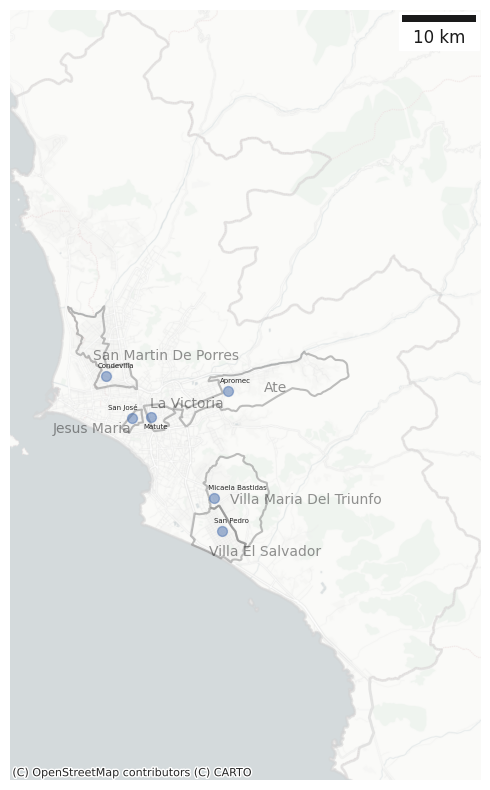

In [42]:
ax = lima_met_smooth.plot(facecolor='none', edgecolor='lightgrey', alpha=0.5, linewidth=2, figsize=(10,10))
districts_with_points.plot(facecolor='none', edgecolor='grey', alpha=0.5, linewidth=1.5, ax=ax)

# Do not plot "El hueco ..."
mcdo_locations.plot(color='b', alpha=0.5, markersize=50, ax=ax)

texts = []

for x, y, label in zip(mcdo_locations.geometry.x, mcdo_locations.geometry.y, mcdo_locations["name"].str.title()):
    a, b = 1, 1
    if "San Jos" in label:
        print(label)
        a, b = 3, 1
        
    if "Real Plaza" in label:
        label="Apromec, "
        #texts.append(plt.text(x-(0.05), y+(0.01), label.split(",")[0].replace("Mercado ", "").replace("Asociacion Centro Comercial ", ""), fontsize=10))
    if "Matute" in label:
        a, b = 1, -1.5
    texts.append(plt.text(x-(a*0.01), y+(b*0.01), label.split(",")[0].replace("Mercado ", "").replace("Plaza", "").replace("De ", "").replace("Asociacion Centro Comercial ", ""), fontsize=5))

for x, y, label in zip(districts_with_points_centroids.geometry.x, districts_with_points_centroids.geometry.y, districts_with_points["DISTRITO"].str.title()):
    a, b = 1, -1
    if "Jes" in label:
        a, b = 10, -1.5
    if "Victo" in label:
        a, b = 1, 1
    if "Salvador" in label:
        a, b = 1, -2.5
    texts.append(plt.text(x-(a*0.01), y+(b*0.01), label, fontsize=10, alpha=0.5))

    
minx, miny, maxx, maxy = lima_met_smooth.total_bounds
margins = 0.001
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

    
ax.add_artist(ScaleBar(distance_meters))

ax.set_axis_off()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.PositronNoLabels, crs=4326)

plt.savefig('outputs/maps/mercados_encuestados.png', dpi=300, bbox_inches='tight')


In [43]:
ollas = gpd.read_file("inputs/Mapeo_de_Ollas_Comunes_-_all_versions_-_Spanish_es_-_2022-12-27-11-18-07.geojson")

In [44]:
districts_with_ollas = districts.sjoin(ollas).drop_duplicates(subset='IDDIST')

In [57]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

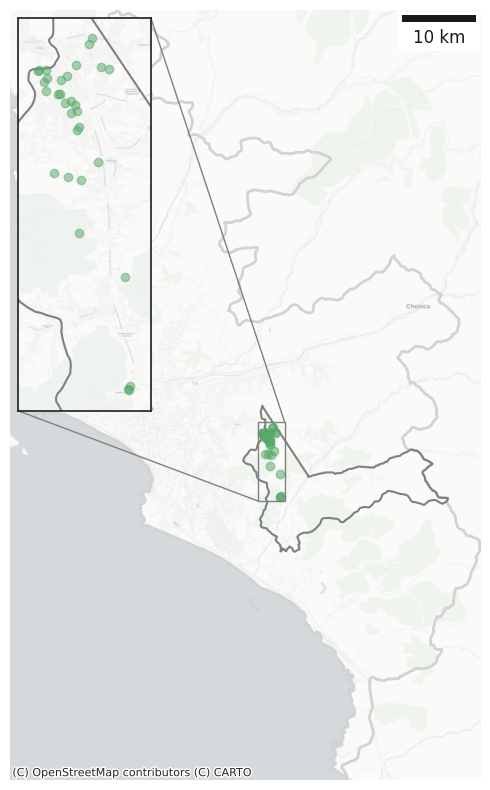

In [50]:
ax = lima_met_smooth.plot(facecolor='none', edgecolor='lightgrey', linewidth=2, figsize=(10,10))
districts_with_ollas.plot(facecolor='none', edgecolor='grey', linewidth=1.5, ax=ax)

ollas.plot(color='g', alpha=0.5, ax=ax)

minx, miny, maxx, maxy = lima_met_smooth.total_bounds
margins = 0.001
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

ax.add_artist(ScaleBar(distance_meters))

ax.set_axis_off()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=4326)

# Use sns style with black frame
with sns.axes_style("white"):
    axins = zoomed_inset_axes(ax, zoom=5, loc='upper left')

    lima_met_smooth.plot(facecolor='none', edgecolor='lightgrey', linewidth=2, ax=axins)
    districts_with_ollas.plot(facecolor='none', edgecolor='grey', linewidth=1.5, ax=axins)

    ollas.plot(color='g', alpha=0.5, ax=axins)

    minx, miny, maxx, maxy = ollas.total_bounds
    margins = 0.005
    axins.set_xlim(minx-margins, maxx+margins)
    axins.set_ylim(miny-margins, maxy+margins)

    plt.setp(axins.get_xticklabels(), visible=False)
    plt.setp(axins.get_yticklabels(), visible=False)
    
    cx.add_basemap(ax=axins, source=cx.providers.CartoDB.Positron, crs=4326, attribution="", zorder=-1 )

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

plt.savefig('outputs/maps/ollas_comunes.png', dpi=300, bbox_inches='tight')

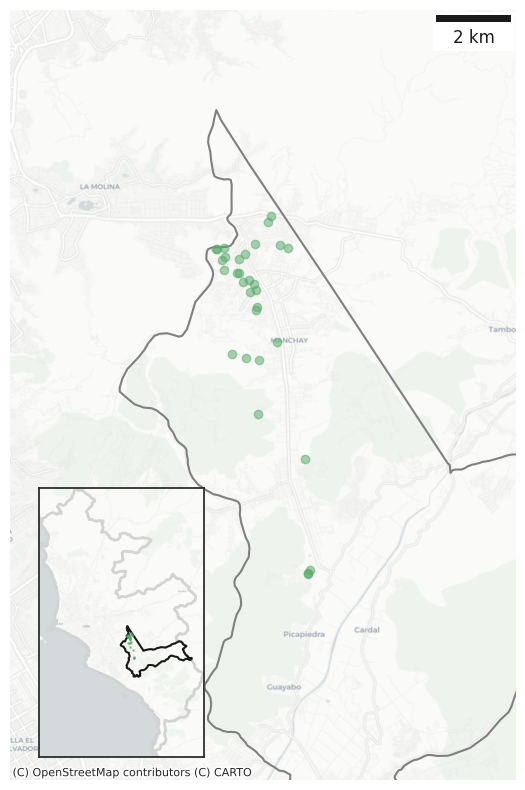

In [102]:
f, ax = plt.subplots(1, 1, figsize=(10,10))

lima_met_smooth.plot(facecolor='none', edgecolor='lightgrey', linewidth=2, ax=ax)
districts_with_ollas.plot(facecolor='none', edgecolor='grey', linewidth=1.5, ax=ax)

ollas.plot(color='g', alpha=0.5, ax=ax)

minx, miny, maxx, maxy = ollas.total_bounds
margins = 0.05
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

ax.add_artist(ScaleBar(distance_meters))

ax.set_axis_off()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=4326)

# Use sns style with black frame
with sns.axes_style("white"):
    axins = inset_axes(ax, width="35%", height="35%", loc='lower left', borderpad=1.5)

    lima_met_smooth.plot(facecolor='none', edgecolor='lightgrey', linewidth=2, ax=axins)
    districts_with_ollas.plot(facecolor='none', edgecolor='k', linewidth=1.5, ax=axins)

    ollas.plot(color='g', markersize=1, alpha=0.5, ax=axins)

    minx, miny, maxx, maxy = lima_met_smooth.total_bounds
    margins = 0.005
    axins.set_xlim(minx-margins, maxx+margins)
    axins.set_ylim(miny-margins, maxy+margins)

    plt.setp(axins.get_xticklabels(), visible=False)
    plt.setp(axins.get_yticklabels(), visible=False)
    
    cx.add_basemap(ax=axins, source=cx.providers.CartoDB.Positron, crs=4326, attribution="", zorder=-1)

plt.savefig('outputs/maps/ollas_comunes_zoomed_out.png', dpi=300, bbox_inches='tight')

## Visualizacion de Flujos de compra 

In [103]:
mcdo_locations

,address,name,geometry
0,"Av Pachacutec 2860, Villa María del Triunfo 15...","Mercado Plaza Micaela Bastidas, Villa María de...",POINT (-76.94854 -12.17331)
2,"Mercado San José, 364, Avenida República Domin...","Mercado San José, Jesús María",POINT (-77.04931 -12.07413)
3,"Mercado San Pedro, Avenida César Vallejo, Sect...","Mercado San Pedro, Villa El Salvador",POINT (-76.93877 -12.21401)
4,"Mercado de la Unidad Vecinal Matute, Javier Lu...","Mercado de Matute, La Victoria",POINT (-77.02614 -12.07296)
5,"Mercado Condevilla, 180, Avenida José Granda, ...","Mercado Condevilla, San Martín de Porres",POINT (-77.08251 -12.02250)
6,"Real Plaza Puruchuco, 4770, Avenida Nicolás de...","Real Plaza Vitarte, Ate Vitarte",POINT (-76.93200 -12.04138)


In [104]:
mcdo_locations["nombre"] = ['Mercado Plaza Micaela Bastidas',
 'Mercado San José',
 'Mercado San Pedro',
 'Mercado de Matute',
 'Mercado Condevilla',
 'Real Plaza Vitarte']

mcdo_locations["lng_mcdo_dest"] = mcdo_locations.geometry.x
mcdo_locations["lat_mcdo_dest"] = mcdo_locations.geometry.y

In [106]:
mcdo_origen_locations["nombre"] = dff_merged['Origen'].unique().tolist()
mcdo_origen_locations["lng_mcdo_orig"] = mcdo_origen_locations.geometry.x
mcdo_origen_locations["lat_mcdo_orig"] = mcdo_origen_locations.geometry.y

In [108]:
df_arcs = dff_merged[['3. Nombre del Mercado',  'Origen']]

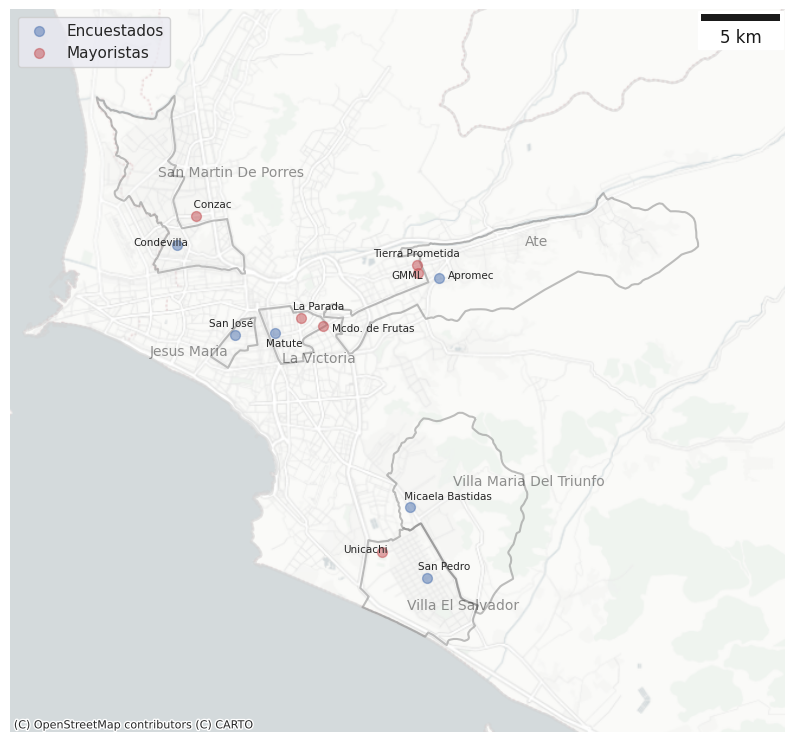

In [272]:
f, ax = plt.subplots(figsize=(10,10))

lima_met_smooth.plot(facecolor='none', edgecolor='lightgrey', alpha=0.5, linewidth=2, ax=ax)
districts_with_points.plot(facecolor='none', edgecolor='grey', alpha=0.5, linewidth=1.5, ax=ax)
mcdo_locations.plot(color='b', alpha=0.5, markersize=50, label='Encuestados', ax=ax)

minx, miny, maxx, maxy = lima_met_smooth.total_bounds
mcdo_origen_loc_filter = mcdo_origen_locations.cx[minx:maxx, miny:maxy]
mcdo_origen_loc_filter.plot(color='r', alpha=0.5, markersize=50, label='Mayoristas', ax=ax)

minx, miny, maxx, maxy = districts_with_points.total_bounds
margins = 0.05
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

factor = 0.5
points_label_fontsize = 7.5
texts = []

for x, y, label in zip(mcdo_locations.geometry.x, mcdo_locations.geometry.y, 
                       mcdo_locations["name"].str.title()):
    a, b = 1, 1
    if "San Jos" in label:
        a, b = 3, 1
    if "Real Plaza" in label:
        label="Apromec, "
        a, b = -1, 0
    if "Matute" in label:
        a, b = 1, -1.5
    if "Condevilla" in label:
        a, b = 5, 0
    a *= factor
    b *= factor
    label = (label.split(",")[0]
             .replace("Mercado ", "")
             .replace("Plaza", "")
             .replace("De ", "")
             .replace("Asociacion Centro Comercial ", "")
    )
    texts.append(plt.text(x-(a*0.01), y+(b*0.01), label, fontsize=points_label_fontsize))

for x, y, label in zip(mcdo_origen_loc_filter.geometry.x, mcdo_origen_loc_filter.geometry.y, 
                       mcdo_origen_loc_filter["name"].str.title()):
    a, b = 1, -1
    if "La Parada" in label:
        b = 1
    if "Tierra" in label:
        a, b = 5, 1
    if "zac" in label:
        a, b = 1, 1
    if "Frutas" in label:
        label = "Mcdo. de Frutas ,"
        a, b = -1, -0.5
    if "Lima" in label:
        label = "GMML"
        a, b = 3, -0.5
    if "Unicachi" in label:
        a, b = 4.5, 0
        
    label = (label.split(",")[0]
             .replace("Gran", "")
             .replace("Mayorista", "")
             .replace("Mercado ", "")
             .replace("Plaza", "")
             .replace("De ", "")
             .replace("Asociacion Centro Comercial ", "")
    )
    a *= factor
    b *= factor
    texts.append(plt.text(x-(a*0.01), y+(b*0.01), label, fontsize=points_label_fontsize))
    
for x, y, label in zip(districts_with_points_centroids.geometry.x, 
                       districts_with_points_centroids.geometry.y,
                       districts_with_points["DISTRITO"].str.title()):
    a, b = 1, 2
    if "Jes" in label:
        a, b = 10, -1.5
    if "Victo" in label:
        a, b = 1, -3.5
    if "Salvador" in label:
        a, b = 1, -2.5
    a *= factor
    b *= factor
    texts.append(plt.text(x-(a*0.01), y+(b*0.01), label, fontsize=10, alpha=0.5))

plt.legend(loc='upper left')

ax.add_artist(ScaleBar(distance_meters))

ax.set_axis_off()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.PositronNoLabels, crs=4326)

plt.savefig('outputs/maps/mercados_encuestados.png', dpi=300, bbox_inches='tight')

In [275]:
lima_hexs = gpd.read_file("/home/claudio/Downloads/lima_hexs_pois.geojson")

In [276]:
lima_hexs.columns

Index(['hex', 'population_2020', 'population_2015', 'population_youth',
       'population_children', 'BFA', 'Manufacturing', 'Other', 'Retail',
       'Services', 'geometry'],
      dtype='object')

In [278]:
lima_hexs_complete = gpd.read_file("https://github.com/Claudio9701/prep-covid-app/raw/f72fee0ed0c7263c5ed69ba9bbba5b4838c495f9/inputs/lima_hexs9_complete.geojson")

In [279]:
lima_hexs_complete.columns

Index(['hex', 'population_2020', 'population_2015', 'population_youth',
       'population_children', 'population_elderly', 'BFA', 'Manufacturing',
       'Other', 'Retail', 'Services', 'Alto', 'Bajo', 'Medio', 'Medio Alto',
       'Medio Bajo', 'missing', 'lat', 'lon', 'nearest_food_facility_ix',
       'distance_to_food_facility', 'duration_to_food_facility',
       'duration_to_food_facility_bins', 'nearest_health_facility_ix',
       'distance_to_health_facility', 'duration_to_health_facility',
       'duration_to_health_facility_bins', 'Ai', 'nj', 'ds', 'INGR_PER',
       'INGR_HOG_PROM', 'vulnerabilidad_monetaria', 'vulnerabilidad_laboral',
       'vulnerabilidad_hidrica', 'geometry'],
      dtype='object')

In [122]:
df_arcs_geo = (df_arcs
    .merge(
        mcdo_locations[['nombre', "lng_mcdo_dest", "lat_mcdo_dest"]],
        how="left",
        left_on="3. Nombre del Mercado", 
        right_on="nombre")
    .rename({"nombre":"Destino"}, axis=1)
    .merge(
        mcdo_origen_locations[['nombre', "lng_mcdo_orig", "lat_mcdo_orig"]],
        how="left",
        left_on="Origen",
        right_on="nombre"
    )
    .drop(["3. Nombre del Mercado", "nombre"], axis=1)
)

In [123]:
df_arcs_geo.head()

,Origen,Destino,lng_mcdo_dest,lat_mcdo_dest,lng_mcdo_orig,lat_mcdo_orig
0,Gran Mercado Mayorista de Lima - Santa Anita,Mercado Plaza Micaela Bastidas,-76.948537,-12.173312,-76.944026,-12.038777
1,Gran Mercado Mayorista de Lima - Santa Anita,Mercado Plaza Micaela Bastidas,-76.948537,-12.173312,-76.944026,-12.038777
2,Mercado Unicachi -Villa El Salvador,Mercado Plaza Micaela Bastidas,-76.948537,-12.173312,-76.964665,-12.199294
3,Mercado Unicachi -Villa El Salvador,Mercado Plaza Micaela Bastidas,-76.948537,-12.173312,-76.964665,-12.199294
4,Mercado Mayorista de Frutas - La Victoria,Mercado Plaza Micaela Bastidas,-76.948537,-12.173312,-76.998505,-12.069217


In [124]:
GREEN_RGB = [0, 255, 0, 40]
RED_RGB = [240, 100, 0, 40]

# Specify a deck.gl ArcLayer
arc_layer = pdk.Layer(
    "ArcLayer",
    data=df_arcs_geo,
    get_width=5,
    get_source_position=["lng_mcdo_orig", "lat_mcdo_orig"],
    get_target_position=["lng_mcdo_dest", "lat_mcdo_dest"],
    get_tilt=15,
    get_source_color=RED_RGB,
    get_target_color=GREEN_RGB,
    pickable=True,
    auto_highlight=True,
)

view_state = pdk.ViewState(
    latitude=-11.7,
    longitude=-76.5,
    #bearing=45,
    pitch=50,
    zoom=7,
)

In [127]:
TOOLTIP_TEXT = {"html": "Destino: {Destino} <br /> Origen: {Origen}"}
r = pdk.Deck(arc_layer, initial_view_state=view_state, tooltip=TOOLTIP_TEXT)
r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

In [126]:
r.to_html("mercados_arcos_v1.html")

## TABLAS

In [128]:
df_main["3. Nombre del Mercado"].unique()

array(['Mercado Plaza Micaela Bastidas',
       'Asociacion Centro Comercial El Hueco del Cono Sur',
       'Mercado San José', 'Mercado San Pedro', 'Mercado de Matute',
       'Mercado Condevilla', 'Real Plaza Vitarte'], dtype=object)

In [129]:
mcdo_nombres_mapper = {
'Mercado Plaza Micaela Bastidas': 'Micaela Bastidas',
'Asociacion Centro Comercial El Hueco del Cono Sur': 'El Hueco',
'Mercado San José': 'San José',
'Mercado San Pedro': 'San Pedro',
'Mercado de Matute': 'Matute',
'Mercado Condevilla': 'Condevilla',
'Real Plaza Vitarte': 'Vitarte',
}

In [130]:
df_main["nombre"] = df_main["3. Nombre del Mercado"].replace(mcdo_nombres_mapper)

In [131]:
df_main["nombre"].unique()

array(['Micaela Bastidas', 'El Hueco', 'San José', 'San Pedro', 'Matute',
       'Condevilla', 'Vitarte'], dtype=object)

In [132]:
df_main["9. Distrito donde vive"].value_counts()

Ate Vitarte                20
Villa María del Triunfo    14
Villa El Salvador           7
La Victoria                 5
San Martín de Porres        5
Santa Anita                 4
Jesús María                 4
San Juan de Lurigancho      4
San Juan de Miraflores      2
El Agustino                 2
Los Olivos                  2
Breña                       1
Pueblo Libre                1
Magdalena del Mar           1
Independencia               1
Name: 9. Distrito donde vive, dtype: int64

In [133]:
# Los comerciantes viven cerca de donde trabajan ?
vive_x_mercado = pd.crosstab(
    df_main["9. Distrito donde vive"],
    df_main["nombre"],
    margins=True,
    margins_name="Total"
)

In [134]:
vive_x_mercado

nombre,Condevilla,El Hueco,Matute,Micaela Bastidas,San José,San Pedro,Vitarte,Total
9. Distrito donde vive,,,,,,,,
Ate Vitarte,0,0,1,0,1,0,18,20
Breña,0,0,0,0,1,0,0,1
El Agustino,0,0,1,0,1,0,0,2
Independencia,0,0,1,0,0,0,0,1
Jesús María,0,0,0,0,4,0,0,4
La Victoria,0,0,4,0,1,0,0,5
Los Olivos,1,0,1,0,0,0,0,2
Magdalena del Mar,0,0,0,0,1,0,0,1
Pueblo Libre,0,0,0,0,1,0,0,1


In [135]:
vive_x_mercado.to_clipboard()

In [136]:
#  Mercados vs Sexo
sexo_x_mcdo = pd.crosstab(
    df_main["nombre"], df_main["8. Sexo"],
    margins=True,
    margins_name="Total")

In [137]:
sexo_x_mcdo.to_clipboard()

In [138]:
# Nivel de estudios vs Estudios completos

In [139]:
df_main["14.1. ¿Qué nivel de estudio tiene?"].unique()

array(['Secundaria', 'Superior Técnico', 'Primaria', nan, 'Universitaria',
       'No alfabetizado'], dtype=object)

In [140]:
df_main["14.1. ¿Qué nivel de estudio tiene?"].isna().sum()

7

In [141]:
df_main["14.1. ¿Qué nivel de estudio tiene?"].value_counts()

Secundaria          44
Primaria            12
Superior Técnico     8
Universitaria        4
No alfabetizado      2
Name: 14.1. ¿Qué nivel de estudio tiene?, dtype: int64

In [142]:
df_main["14.2. ¿Tiene estudios completos?"].unique()

array(['Completo', 'Incompleto', nan], dtype=object)

In [143]:
df_main["14.2. ¿Tiene estudios completos?"].isna().sum()

10

In [144]:
df_main["14.2. ¿Tiene estudios completos?"].value_counts()

Completo      52
Incompleto    15
Name: 14.2. ¿Tiene estudios completos?, dtype: int64

In [145]:
df_main[
    df_main["14.1. ¿Qué nivel de estudio tiene?"].notna() & \
    df_main["14.2. ¿Tiene estudios completos?"].isna()
].iloc[:, :20]

,1. Código del Cuestionario (ID),2. Fecha de la Encuesta,3. Nombre del Mercado,4. Distrito,5. Nombre del Encuestador,6. Nombre del Encuestado,7. Edad,8. Sexo,9. Distrito donde vive,10. ¿Cuántos miembros conforman su hogar? Usted incluido,11. ¿Cuántos miembros de su hogar son hombres?,12. ¿Cuántos miembros de su hogar son mujeres?,13. ¿Cuántos miembros de su hogar son menores de 5 años?,14.1. ¿Qué nivel de estudio tiene?,14.2. ¿Tiene estudios completos?,15. EN LA ACTUALIDAD ¿Su puesto en el mercado es su principal actividad económica?,15.1. Si la repuesta anterior fue No ¿Cuál es su principal actividad económica?,"16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?","16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?",16.2. Seleccione la unidad que corresponde
27,06_VIC_Matute_Melany,2022-11-22,Mercado de Matute,La Victoria,Melany Arango,Angelica Requera,68.0,Femenino,San Juan de Lurigancho,4.0,NaN,NaN,NaN,No alfabetizado,NaN,Sí,NaN,Sí,6.0,Meses
45,02_VMT_Micaela_Antonio,2022-11-02,Mercado Plaza Micaela Bastidas,Villa María del Triunfo,Antonio Bravo,Luz Maria,58.0,Femenino,Villa María del Triunfo,4.0,3.0,1.0,NaN,No alfabetizado,NaN,Sí,NaN,Sí,6.0,Meses
60,03_VIC_Matute_Antonio,2022-11-22,Mercado de Matute,La Victoria,Antonio Bravo,Juan Carlos Aquino,58.0,Masculino,La Victoria,1.0,1.0,NaN,NaN,Secundaria,NaN,Sí,NaN,No,NaN,NaN


In [146]:
df_main.loc[27, "14.2. ¿Tiene estudios completos?"] = "No válido"
df_main.loc[45, "14.2. ¿Tiene estudios completos?"] = "No válido"

In [147]:
nivel_estudios_x_estudio_completo = pd.crosstab(
    df_main["14.1. ¿Qué nivel de estudio tiene?"],
    df_main["14.2. ¿Tiene estudios completos?"],
    margins=True, margins_name="Total"
)

In [148]:
nivel_estudios_x_estudio_completo.to_clipboard()

In [149]:
df_main["nombre"].unique()

array(['Micaela Bastidas', 'El Hueco', 'San José', 'San Pedro', 'Matute',
       'Condevilla', 'Vitarte'], dtype=object)

In [150]:
for nombre in df_main["nombre"].unique():
    print(nombre)
    dff = df_main[df_main["nombre"] == nombre]
    print(pd.crosstab(
        dff["14.1. ¿Qué nivel de estudio tiene?"],
        dff["14.2. ¿Tiene estudios completos?"],
        margins=True, margins_name="Total").to_csv()
    )
    print("------")
    print()

Micaela Bastidas
14.1. ¿Qué nivel de estudio tiene?,Completo,Incompleto,No válido,Total
No alfabetizado,0,0,1,1
Primaria,2,0,0,2
Secundaria,4,0,0,4
Superior Técnico,0,1,0,1
Universitaria,1,1,0,2
Total,7,2,1,10

------

El Hueco
14.1. ¿Qué nivel de estudio tiene?,Completo,Total
Primaria,1,1
Secundaria,4,4
Total,5,5

------

San José
14.1. ¿Qué nivel de estudio tiene?,Completo,Total
Primaria,1,1
Secundaria,7,7
Superior Técnico,1,1
Total,9,9

------

San Pedro
14.1. ¿Qué nivel de estudio tiene?,Completo,Incompleto,Total
Primaria,1,1,2
Secundaria,3,3,6
Total,4,4,8

------

Matute
14.1. ¿Qué nivel de estudio tiene?,Completo,Incompleto,No válido,Total
No alfabetizado,0,0,1,1
Primaria,2,1,0,3
Secundaria,1,4,0,5
Superior Técnico,1,0,0,1
Total,4,5,1,10

------

Condevilla
14.1. ¿Qué nivel de estudio tiene?,Completo,Incompleto,Total
Primaria,1,1,2
Secundaria,4,0,4
Superior Técnico,1,0,1
Total,6,1,7

------

Vitarte
14.1. ¿Qué nivel de estudio tiene?,Completo,Incompleto,Total
Primaria,1,0,1
Secun

In [151]:
df_main["7. Edad"].isna().sum()

10

In [152]:
df_main[df_main["7. Edad"].isna()].iloc[:, :20]

,1. Código del Cuestionario (ID),2. Fecha de la Encuesta,3. Nombre del Mercado,4. Distrito,5. Nombre del Encuestador,6. Nombre del Encuestado,7. Edad,8. Sexo,9. Distrito donde vive,10. ¿Cuántos miembros conforman su hogar? Usted incluido,11. ¿Cuántos miembros de su hogar son hombres?,12. ¿Cuántos miembros de su hogar son mujeres?,13. ¿Cuántos miembros de su hogar son menores de 5 años?,14.1. ¿Qué nivel de estudio tiene?,14.2. ¿Tiene estudios completos?,15. EN LA ACTUALIDAD ¿Su puesto en el mercado es su principal actividad económica?,15.1. Si la repuesta anterior fue No ¿Cuál es su principal actividad económica?,"16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?","16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?",16.2. Seleccione la unidad que corresponde
5,02_VMT_Hueco_Melany,2022-11-02,Asociacion Centro Comercial El Hueco del Cono Sur,Villa María del Triunfo,Melany Arango,NaN,NaN,Masculino,Villa María del Triunfo,NaN,NaN,NaN,NaN,Primaria,Completo,Sí,NaN,No,NaN,NaN
8,03_JM_San_Jose_Melany,2022-11-23,Mercado San José,Jesús María,Melany Arango,Luz,NaN,Femenino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sí,NaN,Sí,4.0,Meses
12,02_VES_Pedro_Melany,2022-11-10,Mercado San Pedro,Villa El Salvador,Melany Arango,NaN,NaN,Femenino,Villa María del Triunfo,NaN,NaN,NaN,NaN,Secundaria,Incompleto,Sí,NaN,No,NaN,NaN
15,05_VES_Pedro_Melany,2022-11-10,Mercado San Pedro,Villa El Salvador,Melany Arango,NaN,NaN,Masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sí,NaN,Sí,6.0,Meses
21,01_VIC_Matute_Melany,2022-11-22,Mercado de Matute,La Victoria,Melany Arango,Nery Rojas,NaN,Femenino,La Victoria,5.0,4.0,1.0,NaN,Primaria,Completo,Sí,NaN,No,NaN,NaN
26,05_VIC_Matute_Melany,2022-11-22,Mercado de Matute,La Victoria,Melany Arango,Jesus,NaN,Masculino,Santa Anita,NaN,NaN,NaN,NaN,NaN,NaN,Sí,NaN,No,NaN,NaN
44,08_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Elias,NaN,Masculino,Santa Anita,NaN,NaN,NaN,NaN,Secundaria,Completo,Sí,NaN,No,NaN,NaN
47,10_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Juan,NaN,Masculino,Ate Vitarte,NaN,NaN,NaN,NaN,Secundaria,Completo,Sí,NaN,No,NaN,NaN
61,04_VIC_Matute_Antonio,2022-11-22,Mercado de Matute,La Victoria,Antonio Bravo,NaN,NaN,Femenino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sí,NaN,Sí,10.0,Meses
64,01_JM_San_Jose_Antonio,2022-11-23,Mercado San José,Jesús María,Antonio Bravo,Ana Serrate,NaN,Femenino,Jesús María,NaN,NaN,NaN,NaN,NaN,NaN,Sí,NaN,Sí,6.0,Meses


In [153]:
df_main["16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?"].unique()

array(['Sí', 'No', 'No sabe / No contesta'], dtype=object)

Text(0, 0.5, 'Frecuencia')

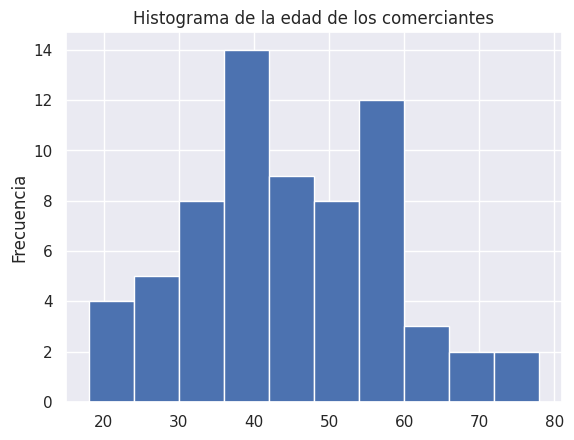

In [154]:
df_main["7. Edad"].hist()
plt.title("Histograma de la edad de los comerciantes")
plt.ylabel("Frecuencia")

In [155]:
df_main["7. Edad"].describe()

count    67.000000
mean     44.492537
std      13.350035
min      18.000000
25%      35.500000
50%      44.000000
75%      54.000000
max      78.000000
Name: 7. Edad, dtype: float64

In [156]:
df_main["7. Edad"]

0     31.0
1     38.0
2     29.0
3     47.0
4     53.0
      ... 
72    48.0
73    38.0
74    30.0
75    27.0
76    55.0
Name: 7. Edad, Length: 77, dtype: float64

In [157]:
df_main["Grupos de edad"] = pd.cut(df_main["7. Edad"], [18, 25, 40, 50, 60, 70])

In [158]:
df_main["8. Sexo"]

0      Femenino
1      Femenino
2      Femenino
3      Femenino
4     Masculino
        ...    
72     Femenino
73     Femenino
74     Femenino
75     Femenino
76    Masculino
Name: 8. Sexo, Length: 77, dtype: object

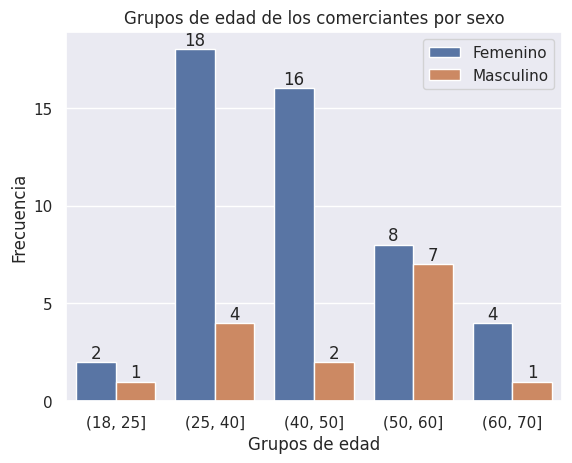

In [159]:
g = sns.countplot(data=df_main, x='Grupos de edad', hue="8. Sexo")
g.set_ylabel("Frecuencia")
g.set_yticks(range(0,20,5))
g.legend_.set_title("")
g.set_title("Grupos de edad de los comerciantes por sexo")
for container in g.containers:
    g.bar_label(container)

In [160]:
edad_x_cerro = pd.crosstab(
    df_main["Grupos de edad"],
    df_main["16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?"],
    margins=True, margins_name="Total"
)[["Sí", "No", "No sabe / No contesta", "Total"]]

In [161]:
edad_x_cerro

"16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?",Sí,No,No sabe / No contesta,Total
Grupos de edad,,,,
"(18, 25]",0,3,0,3
"(25, 40]",9,13,0,22
"(40, 50]",5,13,0,18
"(50, 60]",3,11,1,15
"(60, 70]",4,1,0,5
Total,21,41,1,63


In [162]:
edad_x_cerro.to_clipboard()

In [163]:
nivel_estudio_x_cerro = pd.crosstab(
    df_main["14.1. ¿Qué nivel de estudio tiene?"],
    df_main["16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?"],
    margins=True, margins_name="Total"
)[["Sí", "No", "No sabe / No contesta", "Total"]]

In [164]:
nivel_estudio_x_cerro

"16. DURANTE EL CONFINAMIENTO (2020), ¿Su puesto permaneció cerrado?",Sí,No,No sabe / No contesta,Total
14.1. ¿Qué nivel de estudio tiene?,,,,
No alfabetizado,2,0,0,2
Primaria,5,7,0,12
Secundaria,14,29,1,44
Superior Técnico,0,8,0,8
Universitaria,2,2,0,4
Total,23,46,1,70


In [165]:
nivel_estudio_x_cerro.to_clipboard()

In [166]:
df_main["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"]

0      6.0
1      6.0
2      NaN
3     24.0
4      NaN
      ... 
72     NaN
73     NaN
74     NaN
75     2.0
76     3.0
Name: 16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?, Length: 77, dtype: float64

In [167]:
df_main["16.2. Seleccione la unidad que corresponde"].unique()

array(['Meses', nan, 'Dias'], dtype=object)

In [168]:
df_main["16.2. Seleccione la unidad que corresponde"].isna().sum()

51

In [169]:
df_main["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"].isna().sum()

51

In [170]:
df_main[df_main["16.2. Seleccione la unidad que corresponde"].isna()]["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"].sum()

0.0

In [171]:
df_main[df_main["16.2. Seleccione la unidad que corresponde"] == "Dias"]["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"]

50    24.0
Name: 16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?, dtype: float64

In [172]:
df_main[df_main["16.2. Seleccione la unidad que corresponde"] == "Meses"]["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"]

0      6.0
1      6.0
3     24.0
6      4.0
8      4.0
14     4.0
15     6.0
20     3.0
27     6.0
30    18.0
35     6.0
36    12.0
38     4.0
40     1.0
45     6.0
49     3.0
51     9.0
53     3.0
59     4.0
61    10.0
62    20.0
64     6.0
65     2.0
75     2.0
76     3.0
Name: 16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?, dtype: float64

In [173]:
df_main["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"]

0      6.0
1      6.0
2      NaN
3     24.0
4      NaN
      ... 
72     NaN
73     NaN
74     NaN
75     2.0
76     3.0
Name: 16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?, Length: 77, dtype: float64

In [174]:
# Meses se quedan igual
# Dias se dividen entre 30 (True * 29 = 29 ---> 29 + 1 = 30)
df_main["meses_de_cierre"] = (df_main["16.1. Si la respuesta anterior fue Sí, ¿Por cuánto tiempo?"] / 
((df_main["16.2. Seleccione la unidad que corresponde"] == "Dias") * 29 + 1))

In [175]:
df_main[df_main["16.2. Seleccione la unidad que corresponde"] == "Dias"]["meses_de_cierre"]

50    0.8
Name: meses_de_cierre, dtype: float64

In [176]:
df_main["meses_de_cierre"]

0      6.0
1      6.0
2      NaN
3     24.0
4      NaN
      ... 
72     NaN
73     NaN
74     NaN
75     2.0
76     3.0
Name: meses_de_cierre, Length: 77, dtype: float64

Text(0, 0.5, 'Frecuencia')

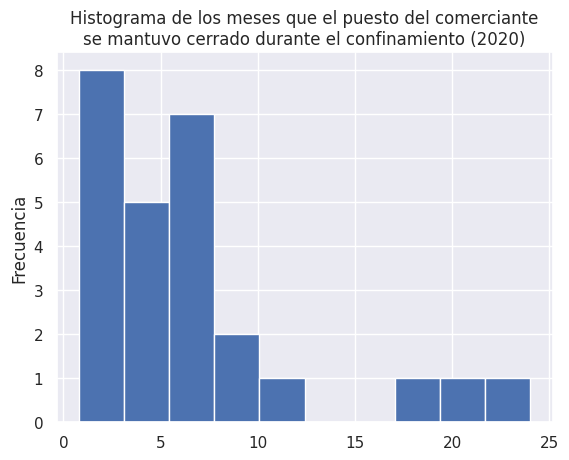

In [177]:
df_main["meses_de_cierre"].hist()
plt.title("Histograma de los meses que el puesto del comerciante\nse mantuvo cerrado durante el confinamiento (2020)")
plt.ylabel("Frecuencia")

In [178]:
df_main["meses_de_cierre_bins"] = pd.cut(df_main["meses_de_cierre"], [0, 6, 12, 24])

In [179]:
edad_x_meses_cerrado = pd.crosstab(
    df_main["Grupos de edad"],
    df_main["meses_de_cierre_bins"],
    margins=True,
    margins_name="Total",
    dropna=False,
)

In [180]:
edad_x_meses_cerrado

meses_de_cierre_bins,"(0, 6]","(6, 12]","(12, 24]",Total
Grupos de edad,,,,
"(18, 25]",0,0,0,3
"(25, 40]",6,2,1,22
"(40, 50]",4,0,1,18
"(50, 60]",2,0,1,15
"(60, 70]",4,0,0,5
Total,20,3,3,77


In [181]:
edad_x_meses_cerrado.to_clipboard()

In [182]:
pd.crosstab(
    df_main["Grupos de edad"],
    df_main["meses_de_cierre_bins"],
    margins=True,
    margins_name="Total",
    dropna=False,
    normalize=True
).round(2) * 100

meses_de_cierre_bins,"(0, 6]","(6, 12]","(12, 24]",Total
Grupos de edad,,,,
"(18, 25]",0.0,0.0,0.0,5.0
"(25, 40]",29.0,10.0,5.0,35.0
"(40, 50]",19.0,0.0,5.0,29.0
"(50, 60]",10.0,0.0,5.0,24.0
"(60, 70]",19.0,0.0,0.0,8.0
Total,77.0,12.0,12.0,100.0


In [183]:
df_main["17. ¿Cuántos días a la semana trabaja en su puesto?"]

0     6
1     7
2     7
3     6
4     7
     ..
72    7
73    7
74    7
75    6
76    7
Name: 17. ¿Cuántos días a la semana trabaja en su puesto?, Length: 77, dtype: int64

In [184]:
df_main["18. ¿Cuántos horas por día trabaja en su puesto?"]

0     12
1     15
2     12
3     12
4     11
      ..
72    12
73    12
74     9
75    15
76    12
Name: 18. ¿Cuántos horas por día trabaja en su puesto?, Length: 77, dtype: int64

In [185]:
df_main["horas_x_sem"] = (df_main["17. ¿Cuántos días a la semana trabaja en su puesto?"] * 
 df_main["18. ¿Cuántos horas por día trabaja en su puesto?"])

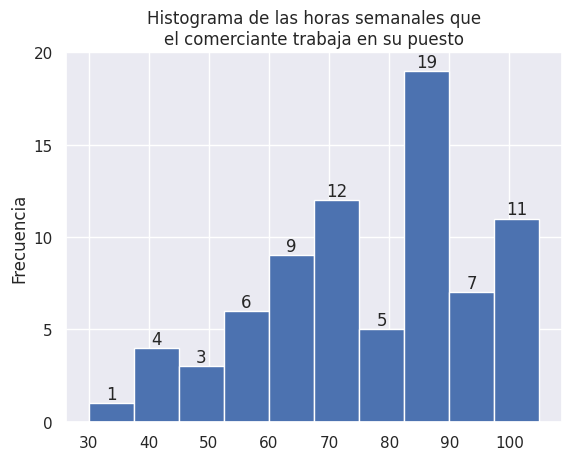

In [ ]:
ax = df_main["horas_x_sem"].hist()
plt.yticks(range(0,21,5))
plt.title("Histograma de las horas semanales que\nel comerciante trabaja en su puesto")
plt.ylabel("Frecuencia")
for container in ax.containers:
    ax.bar_label(container)

In [187]:
horas_x_sem_x_mcdo = df_main.groupby("nombre")["horas_x_sem"].describe().round(2)
horas_x_sem_x_mcdo

,count,mean,std,min,25%,50%,75%,max
nombre,,,,,,,,
Condevilla,7.0,85.14,15.79,56.0,81.00,84.0,94.50,105.0
El Hueco,5.0,78.40,24.95,42.0,70.00,77.0,98.00,105.0
Matute,13.0,53.00,11.94,30.0,42.00,56.0,63.00,72.0
Micaela Bastidas,10.0,83.10,11.99,70.0,72.00,84.0,88.50,105.0
San José,12.0,77.50,15.23,48.0,68.25,80.5,85.75,98.0
San Pedro,9.0,73.44,10.25,56.0,70.00,70.0,77.00,91.0
Vitarte,21.0,81.62,12.75,56.0,84.00,84.0,90.00,98.0


In [165]:
horas_x_sem_x_mcdo.to_clipboard()

In [190]:
horas_x_sem = df_main["horas_x_sem"].describe().round(2).to_frame().T
horas_x_sem

,count,mean,std,min,25%,50%,75%,max
horas_x_sem,77.0,75.49,17.15,30.0,63.0,77.0,84.0,105.0


In [192]:
horas_x_sem.to_clipboard()

Text(0.5, 0, 'Horas semanales que el comerciante trabaja en su puesto')

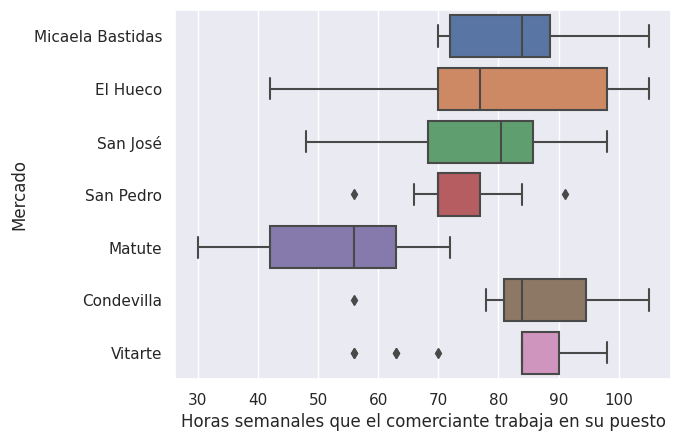

In [166]:
g = sns.boxplot(data=df_main, x="horas_x_sem", y="nombre", hue="nombre", dodge=False)
g.legend_.remove()
g.set_ylabel("Mercado")
g.set_xlabel("Horas semanales que el comerciante trabaja en su puesto")

In [233]:
df_main["19. Sin contar las horas de trabajo en el puesto, ¿Cuántas horas a la semana dedica a realizar las compras para abastecer su puesto?"]

0      3.0
1     14.0
2     12.0
3      3.0
4     12.0
      ... 
72     6.0
73     6.0
74     8.0
75    14.0
76    12.0
Name: 19. Sin contar las horas de trabajo en el puesto, ¿Cuántas horas a la semana dedica a realizar las compras para abastecer su puesto?, Length: 77, dtype: float64

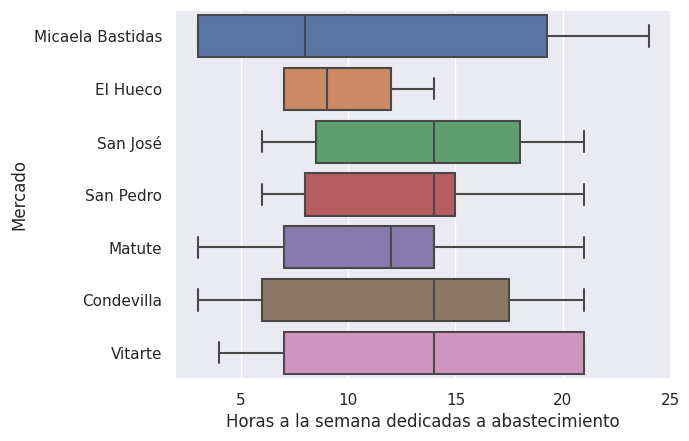

In [268]:
g = sns.boxplot(data=df_main, x="19. Sin contar las horas de trabajo en el puesto, ¿Cuántas horas a la semana dedica a realizar las compras para abastecer su puesto?", 
                y="nombre", hue="nombre", dodge=False)
g.set_xlabel("Horas a la semana dedicadas a abastecimiento")
g.set_ylabel("Mercado")
g.legend_.remove()

In [168]:
df_main["20. ¿Usted ha cambiado la frecuencia de compra de alimentos para abastecer su puesto?"]

0     No
1     Sí
2     Sí
3     No
4     Sí
      ..
72    Sí
73    Sí
74    Sí
75    No
76    Sí
Name: 20. ¿Usted ha cambiado la frecuencia de compra de alimentos para abastecer su puesto?, Length: 77, dtype: object

In [169]:
df_main["20. ¿Usted ha cambiado la frecuencia de compra de alimentos para abastecer su puesto?"].unique()

array(['No', 'Sí'], dtype=object)

In [170]:
df_main["20.1. Si la respuesta es Si, la frecuencia:"]

0           NaN
1     Disminuyo
2     Disminuyo
3           NaN
4     Disminuyo
        ...    
72    Disminuyo
73    Disminuyo
74    Disminuyo
75          NaN
76    Disminuyo
Name: 20.1. Si la respuesta es Si, la frecuencia:, Length: 77, dtype: object

In [171]:
df_main["20.1. Si la respuesta es Si, la frecuencia:"].unique()

array([nan, 'Disminuyo', 'Aumento'], dtype=object)

In [172]:
df_main["var_compra_alim"]  = (df_main["20.1. Si la respuesta es Si, la frecuencia:"]
    .fillna(df_main["20. ¿Usted ha cambiado la frecuencia de compra de alimentos para abastecer su puesto?"]))

In [173]:
df_main["var_compra_alim"].value_counts()

No           38
Disminuyo    33
Aumento       6
Name: var_compra_alim, dtype: int64

In [174]:
df_main["var_compra_alim"] = df_main["var_compra_alim"].replace("No", "Se Mantuvo")

In [175]:
mcdo_var_compra = pd.crosstab(
    df_main["nombre"],
    df_main["var_compra_alim"],
    margins=True,
    margins_name="Total",
    dropna=False,
)
mcdo_var_compra[['Disminuyo', 'Se Mantuvo', 'Aumento', 'Total']]

var_compra_alim,Disminuyo,Se Mantuvo,Aumento,Total
nombre,,,,
Condevilla,4,2,1,7
El Hueco,3,2,0,5
Matute,7,5,1,13
Micaela Bastidas,4,6,0,10
San José,4,8,0,12
San Pedro,2,4,3,9
Vitarte,9,11,1,21
Total,33,38,6,77


In [176]:
mcdo_var_compra.to_clipboard()

In [177]:
df_main["20.2. ¿Por qué motivo?"].value_counts()

Por el incremento de los precios                                   17
Como consecuencia de la pandemia                                   10
Como consecuencia de la pandemia y el incremento de los precios     3
Poca venta de productos                                             2
Falta de dinero para comprar                                        1
Por la inseguridad                                                  1
Por los ambulantes                                                  1
Por la temporada de frutas                                          1
Name: 20.2. ¿Por qué motivo?, dtype: int64

In [178]:
"Por el incremento de los precios"
"Como consecuencia de la pandemia"
"Como consecuencia de la pandemia y el incremento de los precios"
"Poca venta de productos"
"Falta de dinero para comprar"
"Por la inseguridad"
"Por los ambulantes"
"Por la temporada de frutas"

'Por la temporada de frutas'

In [179]:
df_main["22. ¿El puesto donde trabaja es?"].value_counts()

Alquilado                53
Propio                   23
No sabe / No contesta     1
Name: 22. ¿El puesto donde trabaja es?, dtype: int64

In [182]:
propiedad_puesto_x_mcdo = pd.crosstab(
    df_main["nombre"],
    df_main["22. ¿El puesto donde trabaja es?"],
    margins=True,
    margins_name="Total",
    dropna=False,
)[["Propio", "Alquilado", "No sabe / No contesta", "Total"]]
propiedad_puesto_x_mcdo

22. ¿El puesto donde trabaja es?,Propio,Alquilado,No sabe / No contesta,Total
nombre,,,,
Condevilla,2,5,0,7
El Hueco,3,2,0,5
Matute,6,6,1,13
Micaela Bastidas,2,8,0,10
San José,2,10,0,12
San Pedro,2,7,0,9
Vitarte,6,15,0,21
Total,23,53,1,77


In [183]:
propiedad_puesto_x_mcdo.to_clipboard()

In [184]:
propiedad_puesto_x_mcdo_norm = pd.crosstab(
    df_main["nombre"],
    df_main["22. ¿El puesto donde trabaja es?"],
    dropna=False,
).divide(df_main["nombre"].value_counts(), axis=0).round(2) * 100

propiedad_puesto_x_mcdo_norm[["Propio", "Alquilado", "No sabe / No contesta"]]

22. ¿El puesto donde trabaja es?,Propio,Alquilado,No sabe / No contesta
Condevilla,29.0,71.0,0.0
El Hueco,60.0,40.0,0.0
Matute,46.0,46.0,8.0
Micaela Bastidas,20.0,80.0,0.0
San José,17.0,83.0,0.0
San Pedro,22.0,78.0,0.0
Vitarte,29.0,71.0,0.0


In [185]:
df_main["23. ¿Desde cuándo atiende su puesto en el mercado?"].unique()

array([ 6.,  5., 36., 72., 30., 13., 20., 10.,  8.,  2., 11., 14.,  3.,
       12.,  7., nan,  4.,  1., 15.])

In [186]:
df_main["23. ¿Desde cuándo atiende su puesto en el mercado?"].isna().sum()

3

In [187]:
df_main["23.1. Indicar unidad de tiempo"].unique()

array(['Meses', 'Años', nan], dtype=object)

In [188]:
df_main["23.1. Indicar unidad de tiempo"].isna().sum()

3

In [189]:
df_main["23.1. Indicar unidad de tiempo"].value_counts()

Años     66
Meses     8
Name: 23.1. Indicar unidad de tiempo, dtype: int64

In [190]:
(df_main["23.1. Indicar unidad de tiempo"] == "Meses") * 11 + 1

0     12
1      1
2     12
3     12
4      1
      ..
72     1
73     1
74     1
75     1
76     1
Name: 23.1. Indicar unidad de tiempo, Length: 77, dtype: int64

In [191]:
df_main["años_atiende_puestos"] = (df_main["23. ¿Desde cuándo atiende su puesto en el mercado?"] / 
((df_main["23.1. Indicar unidad de tiempo"] == "Meses") * 11 + 1))

In [192]:
df_main["años_atiende_puestos"].describe()

count    74.000000
mean      7.905405
std       6.207739
min       0.166667
25%       3.000000
50%       6.500000
75%      11.000000
max      30.000000
Name: años_atiende_puestos, dtype: float64

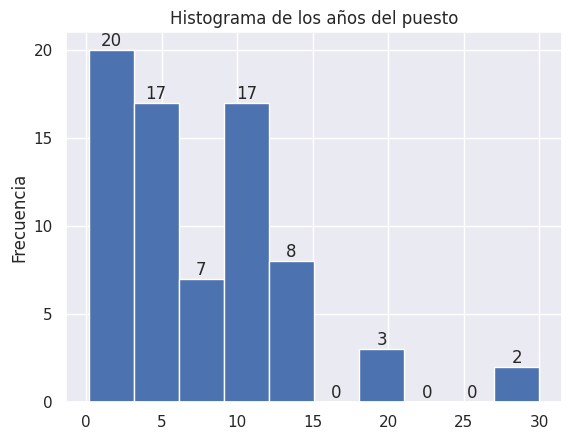

In [193]:
ax = df_main["años_atiende_puestos"].hist()
plt.yticks(range(0,21,5))
plt.title("Histograma de los años del puesto")
plt.ylabel("Frecuencia")
for container in ax.containers:
    ax.bar_label(container)

In [194]:
df_main["años_atiende_puestos_cat"] = pd.cut(df_main["años_atiende_puestos"], [0,1,5,10,30])

In [196]:
años_x_mercado = pd.crosstab(
    df_main["nombre"],
    df_main["años_atiende_puestos_cat"],
    margins=True,
    margins_name="Total",
    dropna=False,
)

In [197]:
años_x_mercado

años_atiende_puestos_cat,"(0, 1]","(1, 5]","(5, 10]","(10, 30]",Total
nombre,,,,,
Condevilla,0,2,4,1,7
El Hueco,0,0,0,4,5
Matute,0,4,3,5,13
Micaela Bastidas,2,6,2,0,10
San José,1,2,6,3,12
San Pedro,3,3,0,3,9
Vitarte,3,6,7,4,21
Total,9,23,22,20,77


In [198]:
años_x_mercado.to_clipboard()

In [363]:
pd.crosstab(
    df_main["nombre"],
    df_main["años_atiende_puestos_cat"],
    dropna=False,
).divide(df_main["nombre"].value_counts(), axis=0).round(2) * 100

años_atiende_puestos_cat,"(0, 1]","(1, 5]","(5, 10]","(10, 30]"
Condevilla,0.0,29.0,57.0,14.0
El Hueco,0.0,0.0,0.0,80.0
Matute,0.0,31.0,23.0,38.0
Micaela Bastidas,20.0,60.0,20.0,0.0
San José,8.0,17.0,50.0,25.0
San Pedro,33.0,33.0,0.0,33.0
Vitarte,14.0,29.0,33.0,19.0


Text(0, 0.5, 'Mercado')

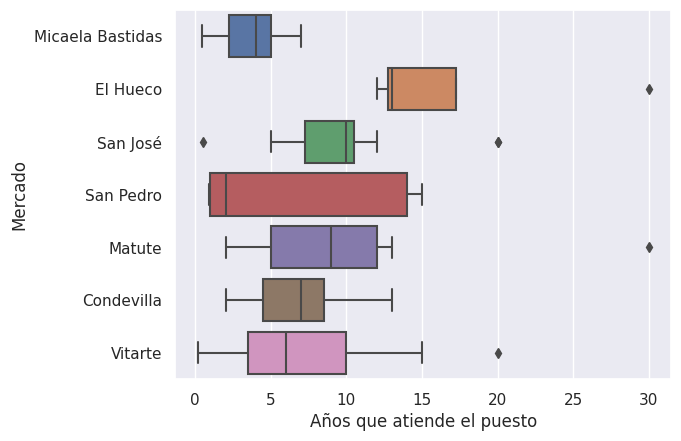

In [199]:
g = sns.boxplot(data=df_main, x="años_atiende_puestos", y="nombre", hue="nombre", dodge=False)
g.legend_.remove()
g.set_xlabel("Años que atiende el puesto")
g.set_ylabel("Mercado")



In [200]:
df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"].unique()

array(['S/1001 – S/2000', 'más de S/3000', 'S/.501– S/1000',
       'No sabe / No contesta', 'S/2001 – S/3000', 'menos de S/.500', nan],
      dtype=object)

In [202]:
inversion_x_mercado = pd.crosstab(
    df_main["nombre"],
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    margins=True,
    margins_name="Total",
    dropna=False,
)[['No sabe / No contesta', 'menos de S/.500', 'S/.501– S/1000',
   'S/1001 – S/2000', 'S/2001 – S/3000', 'más de S/3000', 'Total']]

In [203]:
inversion_x_mercado

30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,No sabe / No contesta,menos de S/.500,S/.501– S/1000,S/1001 – S/2000,S/2001 – S/3000,más de S/3000,Total
nombre,,,,,,,
Condevilla,0,1,1,3,2,0,7
El Hueco,0,1,2,1,0,0,5
Matute,1,2,3,4,0,3,13
Micaela Bastidas,1,0,1,6,0,2,10
San José,0,0,3,5,1,3,12
San Pedro,2,1,3,2,1,0,9
Vitarte,0,1,2,14,2,2,21
Total,4,6,15,35,6,10,77


In [204]:
inversion_x_mercado.to_clipboard()

In [205]:
df_main["32. Tomando el año 2019 (antes de la pandemia) como referencia, en la actualidad sus ingresos mensuales:"]

0     No sabe / No contesta
1     No sabe / No contesta
2     No sabe / No contesta
3     No sabe / No contesta
4              disminuyeron
              ...          
72             Disminuyeron
73             Disminuyeron
74             Disminuyeron
75     Se mantuvieron igual
76             Disminuyeron
Name: 32. Tomando el año 2019 (antes de la pandemia) como referencia, en la actualidad sus ingresos mensuales:, Length: 77, dtype: object

In [206]:
df_main["32. Tomando el año 2019 (antes de la pandemia) como referencia, en la actualidad sus ingresos mensuales:"].value_counts()

disminuyeron             27
No sabe / No contesta    20
Disminuyeron             15
Se mantuvieron igual      8
Aumentaron                6
Name: 32. Tomando el año 2019 (antes de la pandemia) como referencia, en la actualidad sus ingresos mensuales:, dtype: int64

In [214]:
df_main["ingresos_mensuales_respecto_a_2019"] = (df_main["32. Tomando el año 2019 (antes de la pandemia) como referencia, en la actualidad sus ingresos mensuales:"]
.replace({
    "disminuyeron": "Disminuyeron",
    "Se mantuvieron igual": "Se Mantuvieron",
}))

In [215]:
df_main["ingresos_mensuales_respecto_a_2019"].value_counts()

Disminuyeron             42
No sabe / No contesta    20
Se Mantuvieron            8
Aumentaron                6
Name: ingresos_mensuales_respecto_a_2019, dtype: int64

In [216]:
df_main["ingresos_mensuales_respecto_a_2019"].unique()

array(['No sabe / No contesta', 'Disminuyeron', 'Aumentaron',
       'Se Mantuvieron', nan], dtype=object)

In [217]:
ingresos_x_mercados = pd.crosstab(
    df_main["nombre"],
    df_main["ingresos_mensuales_respecto_a_2019"],
    margins=True,
    margins_name="Total",
    dropna=False,
)[['No sabe / No contesta', 'Disminuyeron', 'Se Mantuvieron', 'Aumentaron', 'Total']]

In [218]:
ingresos_x_mercados

ingresos_mensuales_respecto_a_2019,No sabe / No contesta,Disminuyeron,Se Mantuvieron,Aumentaron,Total
nombre,,,,,
Condevilla,1,6,0,0,7
El Hueco,0,5,0,0,5
Matute,1,7,4,1,13
Micaela Bastidas,5,5,0,0,10
San José,3,5,0,4,12
San Pedro,2,4,2,1,9
Vitarte,8,10,2,0,21
Total,20,42,8,6,77


In [219]:
ingresos_x_mercados.to_clipboard()

In [220]:
inversion_x_ingreso = pd.crosstab(
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    df_main["ingresos_mensuales_respecto_a_2019"],
    margins=True,
    margins_name="Total",
    dropna=False,
).loc[['No sabe / No contesta', 'menos de S/.500', 'S/.501– S/1000',
   'S/1001 – S/2000', 'S/2001 – S/3000', 'más de S/3000', 'Total']]

In [221]:
inversion_x_ingreso

ingresos_mensuales_respecto_a_2019,Aumentaron,Disminuyeron,No sabe / No contesta,Se Mantuvieron,Total
30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,,,,,
No sabe / No contesta,0,3,1,0,4
menos de S/.500,0,4,1,1,6
S/.501– S/1000,1,8,5,1,15
S/1001 – S/2000,3,17,11,4,35
S/2001 – S/3000,0,5,1,0,6
más de S/3000,2,4,1,2,10
Total,6,42,20,8,77


In [222]:
inversion_x_ingreso.to_clipboard()

In [223]:
df_main["34. ¿Usted es miembro de la Asociación de Comerciantes del Mercado?"].unique()

array(['No', 'Sí', nan], dtype=object)

In [224]:
# Cruzar 34 miembro de asoc. vs tipo de propiedad del puesto
propiedad_x_miembro_asoc = pd.crosstab(
    df_main["22. ¿El puesto donde trabaja es?"],
    df_main["34. ¿Usted es miembro de la Asociación de Comerciantes del Mercado?"],
    margins=True,
    margins_name="Total",
    dropna=False,
).loc[["Propio", "Alquilado", "No sabe / No contesta", "Total"]]

In [225]:
propiedad_x_miembro_asoc

34. ¿Usted es miembro de la Asociación de Comerciantes del Mercado?,No,Sí,Total
22. ¿El puesto donde trabaja es?,,,
Propio,11,12,23
Alquilado,36,16,53
No sabe / No contesta,1,0,1
Total,48,28,77


In [226]:
propiedad_x_miembro_asoc.to_clipboard()

In [227]:
df_main["35. ¿Separa los desechos organicos de los inorganicos?"].unique()

array(['Sí', 'No', nan], dtype=object)

In [228]:
inversion_x_desechos = pd.crosstab(
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    df_main["35. ¿Separa los desechos organicos de los inorganicos?"],
    margins=True,
    margins_name="Total",
    dropna=False,
).loc[['No sabe / No contesta', 'menos de S/.500', 'S/.501– S/1000',
   'S/1001 – S/2000', 'S/2001 – S/3000', 'más de S/3000', 'Total']]

In [229]:
inversion_x_desechos

35. ¿Separa los desechos organicos de los inorganicos?,No,Sí,Total
30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,,,
No sabe / No contesta,3,1,4
menos de S/.500,5,1,6
S/.501– S/1000,7,8,15
S/1001 – S/2000,18,16,35
S/2001 – S/3000,4,2,6
más de S/3000,5,5,10
Total,43,33,77


In [230]:
inversion_x_desechos.to_clipboard()

In [231]:
df_main["35.1. ¿Cuál es el destino principal de los residuos orgánicos que el puesto genera?"].unique()

array(['Compost', nan, 'Comida para animales',
       'Basura Comida para animales', 'Basura', 'Otro',
       'Basura Compost Comida para animales'], dtype=object)

In [232]:
# por mercado 35.1 (eliminar otro) COMO VISUALIZAR?

'Basura Comida para animales': 'Comida para animales', 'Basura', 'Otro', 
'Basura Compost Comida para animales'



'Compost', 'Comida para animales', 'Basura Comida para animales', 'Basura', 'Otro', 'Basura Compost Comida para animales'

SyntaxError: illegal target for annotation (3414057816.py, line 3)

In [234]:
df_main["36. ¿Usted ha comprado/compra productos directamente a los agricultores?"].unique()

array(['No', 'Sí'], dtype=object)

In [236]:
inversion_x_compra_directa = pd.crosstab(
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    df_main["36. ¿Usted ha comprado/compra productos directamente a los agricultores?"],
    margins=True,
    margins_name="Total",
    dropna=False,
).loc[['No sabe / No contesta', 'menos de S/.500', 'S/.501– S/1000',
   'S/1001 – S/2000', 'S/2001 – S/3000', 'más de S/3000', 'Total']]

In [237]:
inversion_x_compra_directa

36. ¿Usted ha comprado/compra productos directamente a los agricultores?,No,Sí,Total
30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,,,
No sabe / No contesta,4,0,4
menos de S/.500,6,0,6
S/.501– S/1000,14,1,15
S/1001 – S/2000,30,5,35
S/2001 – S/3000,4,2,6
más de S/3000,9,1,10
Total,68,9,77


In [238]:
inversion_x_compra_directa.to_clipboard()

In [242]:
df_main["36.6 . ¿Compraría productos directamente a los agricultores?"].unique()

array(['Sí', 'No', nan], dtype=object)

In [243]:
df_main["36.6 . ¿Compraría productos directamente a los agricultores?"].isna().sum()

9

In [244]:
df_main["36.7. ¿Por qué?"].unique()

array(['Más saludable', 'No le interesa', nan,
       'Por la distancia que costaría más', 'No es rentable',
       'Falta de tiempo y prefiere comprar en el mercado mayorista',
       'Porque los costos de transporte serían mas costosos',
       'No tiene espacio para almacenar',
       'Se tendría que comprar en cantidad',
       'Por el precio y se tendría que comprar en cantidad',
       'Se tendría que comprar en cantidad y no hay variedad',
       'Falta de tiempo para comprar y el dinero que se necesitaría',
       'Falta de tiempo para comprar', 'En el mayorista hay más variedad'],
      dtype=object)

In [245]:
df_main["36.7. ¿Por qué?"].isna().sum()

29

In [247]:
df_main[
    df_main["36.6 . ¿Compraría productos directamente a los agricultores?"] == "Sí"
]["36.7. ¿Por qué?"].unique()

array(['Más saludable', nan], dtype=object)

In [258]:
df_main[
    df_main["36.6 . ¿Compraría productos directamente a los agricultores?"] == "No"
]["36.7. ¿Por qué?"].unique()

array(['No le interesa', nan, 'Por la distancia que costaría más',
       'No es rentable',
       'Falta de tiempo y prefiere comprar en el mercado mayorista',
       'Porque los costos de transporte serían mas costosos',
       'No tiene espacio para almacenar',
       'Se tendría que comprar en cantidad',
       'Por el precio y se tendría que comprar en cantidad',
       'Se tendría que comprar en cantidad y no hay variedad',
       'Falta de tiempo para comprar y el dinero que se necesitaría',
       'Falta de tiempo para comprar', 'En el mayorista hay más variedad'],
      dtype=object)

In [251]:
motivos_replace = {
    # Precio elevado
    'Por la distancia que costaría más': "Precio elevado",
    'Porque los costos de transporte serían mas costosos': "Precio elevado",
    'No es rentable': "Precio elevado",
    'Por el precio y se tendría que comprar en cantidad': "Precio elevado",
    'Se tendría que comprar en cantidad': "Precio elevado",
    'Se tendría que comprar en cantidad y no hay variedad': "Precio elevado",

    # Prefiere mayorista
    'Falta de tiempo y prefiere comprar en el mercado mayorista': "Prefiere mayorista",
    'En el mayorista hay más variedad': "Prefiere mayorista",

    # Falta de espacio
    'No tiene espacio para almacenar': "Falta de espacio",

    # Falta de tiempo
    'Falta de tiempo para comprar y el dinero que se necesitaría': "Falta de tiempo",
    'Falta de tiempo para comprar': "Falta de tiempo", 
}   
    

In [263]:
df_main["motivo_compra_directa"] = df_main["36.7. ¿Por qué?"].replace(motivos_replace)

In [265]:
df_main["36.6 . ¿Compraría productos directamente a los agricultores?"]

0      Sí
1      No
2      No
3      Sí
4      No
     ... 
72    NaN
73     Sí
74     No
75    NaN
76     No
Name: 36.6 . ¿Compraría productos directamente a los agricultores?, Length: 77, dtype: object

In [270]:
compra_directa_x_motivo = pd.crosstab(
    df_main["motivo_compra_directa"],
    df_main["36.6 . ¿Compraría productos directamente a los agricultores?"],
    margins=True,
    margins_name="Total",
    dropna=False
)
compra_directa_x_motivo

36.6 . ¿Compraría productos directamente a los agricultores?,No,Sí,Total
motivo_compra_directa,,,
Falta de espacio,1,0,1
Falta de tiempo,2,0,2
Más saludable,0,1,1
No le interesa,26,0,26
Precio elevado,16,0,16
Prefiere mayorista,2,0,2
Total,53,15,77


In [271]:
compra_directa_x_motivo.to_clipboard()

In [274]:
inversion_x_tipo_compra = pd.crosstab(
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    df_main["36.8. ¿Que tipo de compra preferiria?"],
    margins=True,
    margins_name="Total",
)
inversion_x_tipo_compra

36.8. ¿Que tipo de compra preferiria?,Corporativa,Individual,Mixta,Total
30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,,,,
S/.501– S/1000,0,1,1,2
S/1001 – S/2000,3,5,1,9
S/2001 – S/3000,1,0,0,1
más de S/3000,1,1,0,2
Total,5,7,2,14


In [275]:
inversion_x_tipo_compra.to_clipboard()

In [277]:
df_main["43. ¿Durante la pandemia entregó alimentos en donación o para recuperación?"].unique()

array(['No', 'Sí'], dtype=object)

In [280]:
df_main["43.1. ¿A quién brindó apoyo?"].unique()

array([nan, 'Otro', 'Olla comun'], dtype=object)

In [286]:
df_main["43.1. ¿A quiénes brindó apoyo?"].unique()

array([nan, 'Otro', 'Olla comun', 'Personas que lo pedian en el puesto',
       'Familiares', 'Personas que pasaban', 'Amigos',
       'Personas que lo pedían en el puesto',
       'Familiares, Iglesia, Olla Comun',
       'personas que pedian en el puesto',
       'Personas que le pedian en el puesto', 'Amigos Olla comun'],
      dtype=object)

In [295]:
a_quienes_brindo_apoyo_replace = {
    # Olla comun
    'Familiares, Iglesia, Olla Comun': "Olla comun",
    'Amigos Olla comun': "Olla comun",
    # 'Personas que lo pedían en el puesto'
    'Personas que lo pedian en el puesto': 'Personas que lo pedían en el puesto',
    'Personas que lo pedían en el puesto': 'Personas que lo pedían en el puesto',
    'Personas que pasaban': 'Personas que lo pedían en el puesto', 
    'personas que pedian en el puesto': 'Personas que lo pedían en el puesto',
    'Personas que le pedian en el puesto': 'Personas que lo pedían en el puesto',
    # Otros
    'Familiares': "Otro", 
    'Amigos': "Otro",
}

In [296]:
df_main["a_quienes_brindo_apoyo_clean"] = df_main["43.1. ¿A quiénes brindó apoyo?"].replace(a_quienes_brindo_apoyo_replace)

In [297]:
df_main["a_quienes_brindo_apoyo_clean"].value_counts()

Olla comun                             19
Otro                                   10
Personas que lo pedían en el puesto     7
Name: a_quienes_brindo_apoyo_clean, dtype: int64

In [298]:
mercado_x_brindo_apoyo = pd.crosstab(
    df_main["nombre"],
    df_main["43. ¿Durante la pandemia entregó alimentos en donación o para recuperación?"],
    margins=True,
    margins_name="Total",
)
mercado_x_brindo_apoyo

43. ¿Durante la pandemia entregó alimentos en donación o para recuperación?,No,Sí,Total
nombre,,,
Condevilla,4,3,7
El Hueco,1,4,5
Matute,10,3,13
Micaela Bastidas,5,5,10
San José,7,5,12
San Pedro,7,2,9
Vitarte,3,18,21
Total,37,40,77


In [310]:
mercado_x_brindo_apoyo.to_clipboard()

In [308]:
inversion_x_brindo_apoyo = pd.crosstab(
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    df_main["43. ¿Durante la pandemia entregó alimentos en donación o para recuperación?"],
    margins=True,
    margins_name="Total",
)
inversion_x_brindo_apoyo

43. ¿Durante la pandemia entregó alimentos en donación o para recuperación?,No,Sí,Total
30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,,,
No sabe / No contesta,3,1,4
S/.501– S/1000,7,8,15
S/1001 – S/2000,16,19,35
S/2001 – S/3000,2,4,6
menos de S/.500,4,2,6
más de S/3000,5,5,10
Total,37,39,76


In [309]:
inversion_x_brindo_apoyo.to_clipboard()

In [304]:
df_main["a_quienes_brindo_apoyo_clean"].unique()

array([nan, 'Otro', 'Olla comun', 'Personas que lo pedían en el puesto'],
      dtype=object)

In [306]:
mercado_x_a_quien_brindo_apoyo = pd.crosstab(
    df_main["nombre"],
    df_main["a_quienes_brindo_apoyo_clean"],
    margins=True,
    margins_name="Total",
).loc[:, ['Olla comun', 'Personas que lo pedían en el puesto', 'Otro', "Total"]]
mercado_x_a_quien_brindo_apoyo

a_quienes_brindo_apoyo_clean,Olla comun,Personas que lo pedían en el puesto,Otro,Total
nombre,,,,
Condevilla,0,1,1,2
El Hueco,0,1,2,3
Matute,0,2,1,3
Micaela Bastidas,2,0,3,5
San José,0,2,2,4
San Pedro,0,1,1,2
Vitarte,17,0,0,17
Total,19,7,10,36


In [307]:
mercado_x_a_quien_brindo_apoyo.to_clipboard()

In [ ]:
df_main["43.2. ¿Con qué frecuencia brindó ese apoyo?"].unique()

In [317]:
mercado_x_frec_apoyo = pd.crosstab(
    df_main["nombre"],
    df_main["43.2. ¿Con qué frecuencia brindó ese apoyo?"],
    margins=True,
    margins_name="Total",
)[['Una sola vez', 'Algunas veces', 'Frecuentemente', 'Siempre', 'Total']]
mercado_x_frec_apoyo

43.2. ¿Con qué frecuencia brindó ese apoyo?,Una sola vez,Algunas veces,Frecuentemente,Siempre,Total
nombre,,,,,
Condevilla,1,2,0,0,3
El Hueco,0,3,1,0,4
Matute,0,3,0,0,3
Micaela Bastidas,0,3,2,0,5
San José,0,5,0,0,5
San Pedro,0,2,0,0,2
Vitarte,0,7,10,1,18
Total,1,25,13,1,40


In [318]:
mercado_x_frec_apoyo.to_clipboard()

In [319]:
df_main["43.3. ¿Actualmente, aún brinda el apoyo?"].unique()

array([nan, 'Sí', 'No'], dtype=object)

In [322]:
mercado_x_siguen_brindando_apoyo = pd.crosstab(
    df_main["nombre"],
    df_main["43.3. ¿Actualmente, aún brinda el apoyo?"],
    margins=True,
    margins_name="Total",
)
mercado_x_siguen_brindando_apoyo

"43.3. ¿Actualmente, aún brinda el apoyo?",No,Sí,Total
nombre,,,
Condevilla,2,1,3
El Hueco,2,1,3
Matute,1,2,3
Micaela Bastidas,1,4,5
San José,4,1,5
San Pedro,1,1,2
Vitarte,14,4,18
Total,25,14,39


In [323]:
mercado_x_siguen_brindando_apoyo.to_clipboard()

In [324]:
df_main["43.4. ¿A quién brindó apoyo?"].unique()

array([nan, 'Otro', 'Olla comun', 'Iglesia', 'Familiares'], dtype=object)

In [325]:
mercado_x_a_quien_brindan_apoyo_ahora = pd.crosstab(
    df_main["nombre"],
    df_main["43.4. ¿A quién brindó apoyo?"],
    margins=True,
    margins_name="Total",
)
mercado_x_a_quien_brindan_apoyo_ahora

43.4. ¿A quién brindó apoyo?,Familiares,Iglesia,Olla comun,Otro,Total
nombre,,,,,
Condevilla,0,1,0,0,1
El Hueco,0,0,0,1,1
Matute,0,0,0,2,2
Micaela Bastidas,1,0,2,1,4
San José,0,0,0,1,1
San Pedro,0,0,0,1,1
Vitarte,1,0,3,0,4
Total,2,1,5,6,14


In [326]:
mercado_x_a_quien_brindan_apoyo_ahora.to_clipboard()

In [327]:
df_main["45. ¿Cómo se realiza la movilización de productos para el abastecimiento de su puesto?"].unique()

array(['Los comerciantes lo traen en transporte público/taxi',
       'Contratan un servicio de transporte', 'Otro',
       'Proveedores traen los productos',
       'Los comerciantes lo traen en vehículo alquilado',
       'Los comerciantes lo traen en vehículo propio'], dtype=object)

In [328]:
# Tipo de transporte
tipo_transporte_replace = {
    'Los comerciantes lo traen en transporte público/taxi': "Público",
    'Contratan un servicio de transporte': "Servicio de transporte",
    'Proveedores traen los productos': "Delivery del proveedor",
    'Los comerciantes lo traen en vehículo alquilado': "Vehiculo alquilado",
    'Los comerciantes lo traen en vehículo propio': "Vehiculo propio",
}

In [329]:
df_main["tipo_transporte"] = df_main["45. ¿Cómo se realiza la movilización de productos para el abastecimiento de su puesto?"].replace(tipo_transporte_replace)

In [331]:
df_main["tipo_transporte"].value_counts()

Público                   51
Delivery del proveedor     8
Otro                       6
Vehiculo alquilado         6
Vehiculo propio            4
Servicio de transporte     2
Name: tipo_transporte, dtype: int64

In [337]:
df_main["tipo_transporte"].unique()

array(['Público', 'Servicio de transporte', 'Otro',
       'Delivery del proveedor', 'Vehiculo alquilado', 'Vehiculo propio'],
      dtype=object)

In [339]:
inversion_x_tipo_transporte = pd.crosstab(
    df_main["30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?"],
    df_main["tipo_transporte"],
    margins=True,
    margins_name="Total",
)[['Delivery del proveedor', 'Vehiculo propio', 'Vehiculo alquilado', 
   'Servicio de transporte', 'Público', 'Otro', 'Total']]
inversion_x_tipo_transporte

tipo_transporte,Delivery del proveedor,Vehiculo propio,Vehiculo alquilado,Servicio de transporte,Público,Otro,Total
30. ¿Cuánto invierte semanalmente en la compra de productos para abastecer su puesto?,,,,,,,
No sabe / No contesta,1,1,1,0,1,0,4
S/.501– S/1000,1,0,0,0,12,2,15
S/1001 – S/2000,3,0,3,1,25,3,35
S/2001 – S/3000,2,1,0,0,3,0,6
menos de S/.500,0,1,0,0,5,0,6
más de S/3000,1,1,2,0,5,1,10
Total,8,4,6,1,51,6,76


In [340]:
inversion_x_tipo_transporte.to_clipboard()

In [341]:
dff

,1. Código del Cuestionario (ID),2. Fecha de la Encuesta,3. Nombre del Mercado,4. Distrito,5. Nombre del Encuestador,6. Nombre del Encuestado,7. Edad,8. Sexo,9. Distrito donde vive,10. ¿Cuántos miembros conforman su hogar? Usted incluido,...,_uuid,_submission_time,_validation_status,_notes,_status,_submitted_by,_tags,_index,1. Código del Cuestionario (ID).1,nombre
34,01_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Saturnino Gutierrez,54.0,Masculino,Ate Vitarte,NaN,...,0aefd4f3-8b11-4783-9261-89dc64f4b657,2022-12-06 04:17:14,NaN,NaN,submitted_via_web,NaN,NaN,35,01_ATE_APROMEC_Melany,Vitarte
35,02_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Carlos Tunque,30.0,Masculino,Ate Vitarte,NaN,...,6f4820a1-a784-45fe-8985-79c90427fc24,2022-12-06 04:21:50,NaN,NaN,submitted_via_web,NaN,NaN,36,02_ATE_APROMEC_Melany,Vitarte
37,03_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Sisy,36.0,Femenino,Santa Anita,NaN,...,1e1369ce-395a-4bac-8264-cbcef8c4e212,2022-12-06 04:31:13,NaN,NaN,submitted_via_web,NaN,NaN,38,03_ATE_APROMEC_Melany,Vitarte
38,04_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Sosima Susana,66.0,Femenino,Ate Vitarte,NaN,...,ba78be67-2672-4d3f-ac7d-0f82b1bdcfe2,2022-12-06 04:37:56,NaN,NaN,submitted_via_web,NaN,NaN,39,04_ATE_APROMEC_Melany,Vitarte
40,05_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Quispe Felicita,41.0,Femenino,Ate Vitarte,NaN,...,e69d8712-789f-4431-8794-5d8139647737,2022-12-06 04:45:00,NaN,NaN,submitted_via_web,NaN,NaN,41,05_ATE_APROMEC_Melany,Vitarte
41,06_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Hilda,49.0,Femenino,Ate Vitarte,NaN,...,79232200-9a5b-45b4-b3e2-4001e7e96c6b,2022-12-06 04:51:00,NaN,NaN,submitted_via_web,NaN,NaN,42,06_ATE_APROMEC_Melany,Vitarte
43,07_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Herminia,50.0,Femenino,Ate Vitarte,NaN,...,ea2fb57d-dcfd-4007-9cd0-b5fa15988d79,2022-12-06 04:56:53,NaN,NaN,submitted_via_web,NaN,NaN,44,07_ATE_APROMEC_Melany,Vitarte
44,08_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Elias,NaN,Masculino,Santa Anita,NaN,...,c81f3f87-ffda-4656-b25d-27506fc72c1e,2022-12-06 05:03:18,NaN,NaN,submitted_via_web,NaN,NaN,45,08_ATE_APROMEC_Melany,Vitarte
46,09_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Graciela,41.0,Femenino,San Juan de Lurigancho,NaN,...,ac7140b8-8624-40b4-9db9-1acdc1c8077b,2022-12-06 05:10:25,NaN,NaN,submitted_via_web,NaN,NaN,47,09_ATE_APROMEC_Melany,Vitarte
47,10_ATE_APROMEC_Melany,2022-11-25,Real Plaza Vitarte,Ate Vitarte,Melany Arango,Juan,NaN,Masculino,Ate Vitarte,NaN,...,3097243e-e192-4379-94dd-1b78b48b60c6,2022-12-06 05:17:11,NaN,NaN,submitted_via_web,NaN,NaN,48,10_ATE_APROMEC_Melany,Vitarte


In [345]:
dff_merged['Producto'].value_counts()

Cebolla             32
Limón               24
Tomate              24
Papa amarilla       22
Mandarina           20
                    ..
Zapallo italiano     1
Brócoli orgánico     1
Lechuga orgánica     1
Granadilla           1
Papa canchán         1
Name: Producto, Length: 62, dtype: int64

In [348]:
print( dff_merged['Producto'].value_counts().index.tolist() )

['Cebolla', 'Limón', 'Tomate', 'Papa amarilla', 'Mandarina', 'Fresa', 'Manzana israel', 'Palta', 'Ají amarillo', 'Zanahoria', 'Papa yungay', 'Camote', 'Brócoli', 'Piña', 'Choclo', 'Platano', 'Zapallo macre', 'Palta fuerte', 'Lechuga', 'Mango', 'Alverja', 'Espinaca', 'Lucuma', 'Papaya', 'Naranja', 'Beterraga', 'Manzana', 'Vainita', 'Yuca', 'Papa', 'Arandanos', 'Manzana chilena', 'Papa canchay', 'Col china', 'Palta hass', 'Esparragos', 'beterraga', 'Manzana delicia', 'Apio', 'Frejol', 'Sandia', 'Rabanito', 'Granos verdes', 'Pimiento', 'Papa rosada', 'Nabo', 'Poro', 'Olluco', 'Papa huayro', 'Culantro', 'Durazno', 'Champiñones', 'Berenjena', 'Pepino', 'pimiento', 'Alcachofa', 'Caigua', 'Zapallo italiano', 'Brócoli orgánico', 'Lechuga orgánica', 'Granadilla', 'Papa canchán']


In [352]:
dff_merged['Producto'].sort_values().unique()

array(['Ají amarillo', 'Alcachofa', 'Alverja', 'Apio', 'Arandanos',
       'Berenjena', 'Beterraga', 'Brócoli', 'Brócoli orgánico', 'Caigua',
       'Camote', 'Cebolla', 'Champiñones', 'Choclo', 'Col china',
       'Culantro', 'Durazno', 'Esparragos', 'Espinaca', 'Frejol', 'Fresa',
       'Granadilla', 'Granos verdes', 'Lechuga', 'Lechuga orgánica',
       'Limón', 'Lucuma', 'Mandarina', 'Mango', 'Manzana',
       'Manzana chilena', 'Manzana delicia', 'Manzana israel', 'Nabo',
       'Naranja', 'Olluco', 'Palta', 'Palta fuerte', 'Palta hass', 'Papa',
       'Papa amarilla', 'Papa canchay', 'Papa canchán', 'Papa huayro',
       'Papa rosada', 'Papa yungay', 'Papaya', 'Pepino', 'Pimiento',
       'Piña', 'Platano', 'Poro', 'Rabanito', 'Sandia', 'Tomate',
       'Vainita', 'Yuca', 'Zanahoria', 'Zapallo italiano',
       'Zapallo macre', 'beterraga', 'pimiento'], dtype=object)

In [360]:
productos_replace = {
 'Papa': ['Papa amarilla', 'Papa yungay', 'Papa canchay', 'Papa rosada','Papa huayro'],
 'Manzana': ['Manzana israel', 'Manzana chilena', 'Manzana delicia'],
 'Palta': ['Palta fuerte', 'Palta hass', 'Papa canchán'],
 'Brócoli': ['Brócoli', 'Brócoli orgánico'],
 'Lechuga': ['Lechuga orgánica'],
 'Beterraga': ['beterraga'],
 'Pimiento': ['pimiento']
}

productos_replace = {e: k for k, v in productos_replace.items() for e in v }

In [363]:
dff_merged['prod_clean'] = dff_merged['Producto'].replace(productos_replace)

In [364]:
dff_merged['prod_clean'].unique()

array(['Papa', 'Limón', 'Zanahoria', 'Yuca', 'Mandarina', 'Platano',
       'Manzana', 'Cebolla', 'Sandia', 'Palta', 'Mango', 'Olluco',
       'Camote', 'Piña', 'Arandanos', 'Fresa', 'Papaya', 'Choclo',
       'Pimiento', 'Beterraga', 'Lechuga', 'Ají amarillo', 'Rabanito',
       'Tomate', 'Zapallo macre', 'Brócoli', 'Granadilla', 'Apio',
       'Espinaca', 'Alverja', 'Frejol', 'Vainita', 'Pepino',
       'Granos verdes', 'Naranja', 'Col china', 'Zapallo italiano',
       'Esparragos', 'Caigua', 'Alcachofa', 'Champiñones', 'Berenjena',
       'Durazno', 'Culantro', 'Poro', 'Nabo', 'Lucuma'], dtype=object)

In [366]:
prod_cat = {
# Frutas
'Frutas': ['Mandarina', 'Platano', 'Manzana', 'Sandia','Mango', 'Piña', 'Arandanos', 'Fresa', 'Papaya', 'Granadilla', 'Naranja','Durazno', 'Lucuma', 'Palta'],
# Veduras
'Verduras': ['Limón', 'Zanahoria', 'Cebolla', 'Choclo','Tomate', 'Pimiento', 'Beterraga', 'Lechuga', 'Ají amarillo', 'Rabanito', 'Pepino', 'Zapallo macre', 'Brócoli', 'Apio', 'Espinaca', 'Col china', 'Zapallo italiano', 'Esparragos', 'Caigua', 'Alcachofa', 'Berenjena', 'Culantro', 'Poro', 'Nabo', 'Alverja', 'Frejol', 'Vainita', 'Granos verdes'],
# Hongos
'Champiñones': ['Champiñones'],
# Tuberculos
'Tuberculos': ['Papa', 'Yuca','Olluco','Camote']
}        
prod_cat = {e: k for k, v in prod_cat.items() for e in v }

In [367]:
dff_merged['prod_cat'] = dff_merged['prod_clean'].replace(prod_cat)

In [369]:
dff_merged['prod_cat'].value_counts()

Verduras       176
Frutas         121
Tuberculos      56
Champiñones      1
Name: prod_cat, dtype: int64

In [371]:
dff_merged["Cantidad comprada a la semana (kg)"]

0      300.0
1      120.0
2      150.0
3      180.0
4      100.0
       ...  
349    100.0
350     18.0
351     50.0
352     24.5
353      7.0
Name: Cantidad comprada a la semana (kg), Length: 354, dtype: float64

In [388]:
dff_merged["nombre"] = dff_merged["3. Nombre del Mercado"].replace(mcdo_nombres_mapper)

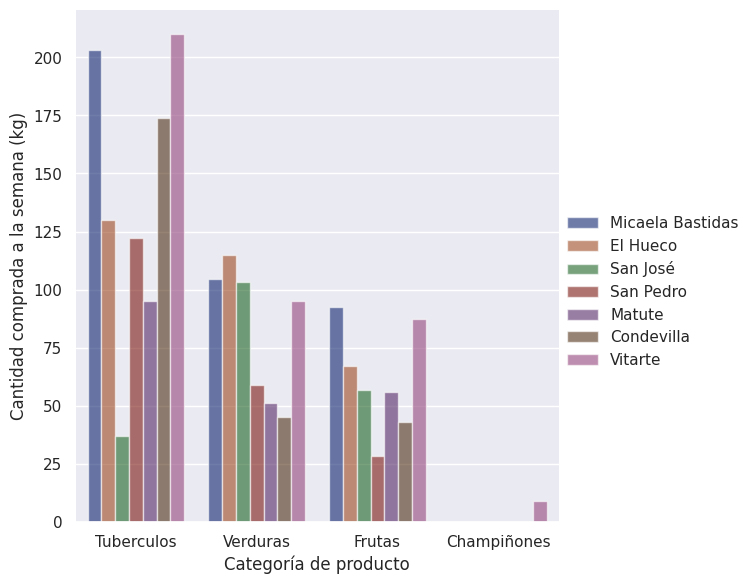

In [389]:
g = sns.catplot(
    data=dff_merged, kind="bar",
    x="prod_cat", y="Cantidad comprada a la semana (kg)", hue="nombre",
    palette="dark", alpha=.6, height=6, errorbar=None,
)
g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
g.set_xlabels("Categoría de producto")
g.legend.set_title("")


In [411]:
promedios_prods_cats_x_mercado = dff_merged.groupby(["nombre", "prod_cat"]).agg({
    "_index_prod": "size",
    "¿Con que frecuencia compra a la semana?": "mean",
    "Cantidad comprada a la semana (kg)": "mean",
    "Cantidad vendida a la semana (kg)": "mean"
})
promedios_prods_cats_x_mercado

_index_prod  \
nombre           prod_cat                   
Condevilla       Frutas                15   
                 Tuberculos             5   
                 Verduras              16   
El Hueco         Frutas                12   
                 Tuberculos             3   
                 Verduras               4   
Matute           Frutas                14   
                 Tuberculos            12   
                 Verduras              41   
Micaela Bastidas Frutas                 9   
                 Tuberculos            15   
                 Verduras              19   
San José         Frutas                26   
                 Tuberculos             5   
                 Verduras              15   
San Pedro        Frutas                12   
                 Tuberculos             8   
                 Verduras              28   
Vitarte          Champiñones            1   
                 Frutas                33   
                 Tuberculos             8   
                 Verduras              53   

                              ¿Con que frecuencia compra a la semana?  \
nombre           prod_cat                                               
Condevilla       Frutas                                      3.466667   
                 Tuberculos                                  1.800000   
                 Verduras                                    3.000000   
El Hueco         Frutas                                      1.916667   
                 Tuberculos                                  1.666667   
                 Verduras                                    2.000000   
Matute           Frutas                                      3.392857   
                 Tuberculos                                  3.625000   
                 Verduras                                    3.014228   
Micaela Bastidas Frutas                                      4.222222   
                 Tuberculos                                  1.866667   
                 Verduras                                    2.210526   
San José         Frutas                                      4.230769   
                 Tuberculos                                  2.400000   
                 Verduras                                    3.133333   
San Pedro        Frutas                                      2.166667   
                 Tuberculos                                  2.250000   
                 Verduras                                    3.035714   
Vitarte          Champiñones                                 3.000000   
                 Frutas                                      2.909091   
                 Tuberculos                                  1.375000   
                 Verduras                                    2.915094   

                              Cantidad comprada a la semana (kg)  \
nombre           prod_cat                                          
Condevilla       Frutas                                42.866667   
                 Tuberculos                           174.000000   
                 Verduras                              45.168750   
El Hueco         Frutas                                66.883333   
                 Tuberculos                           130.000000   
                 Verduras                             115.000000   
Matute           Frutas                                55.964286   
                 Tuberculos                            95.000000   
                 Verduras                              51.335748   
Micaela Bastidas Frutas                                92.444444   
                 Tuberculos                           203.333333   
                 Verduras                             104.355263   
San José         Frutas                                56.615385   
                 Tuberculos                            37.000000   
                 Verduras                             103.116667   
San Pedro        Frutas                 

In [412]:
promedios_prods_cats_x_mercado.to_clipboard()

In [396]:
dff_merged

,3. Nombre del Mercado,4. Distrito,_index_main,Producto,Origen,¿Con que frecuencia compra a la semana?,Cantidad comprada a la semana (kg),Cantidad vendida a la semana (kg),_index_prod,_parent_index,prod_clean,prod_cat,nombre
0,Mercado Plaza Micaela Bastidas,Villa María del Triunfo,1,Papa,Gran Mercado Mayorista de Lima - Santa Anita,3.0,300.0,200.0,1,1,Papa,Tuberculos,Micaela Bastidas
1,Mercado Plaza Micaela Bastidas,Villa María del Triunfo,1,Limón,Gran Mercado Mayorista de Lima - Santa Anita,3.0,120.0,80.0,2,1,Limón,Verduras,Micaela Bastidas
2,Mercado Plaza Micaela Bastidas,Villa María del Triunfo,1,Zanahoria,Mercado Unicachi -Villa El Salvador,3.0,150.0,100.0,3,1,Zanahoria,Verduras,Micaela Bastidas
3,Mercado Plaza Micaela Bastidas,Villa María del Triunfo,1,Yuca,Mercado Unicachi -Villa El Salvador,3.0,180.0,60.0,4,1,Yuca,Tuberculos,Micaela Bastidas
4,Mercado Plaza Micaela Bastidas,Villa María del Triunfo,2,Mandarina,Mercado Mayorista de Frutas - La Victoria,5.0,100.0,100.0,5,2,Mandarina,Frutas,Micaela Bastidas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,Real Plaza Vitarte,Ate Vitarte,77,Cebolla,Gran Mercado Mayorista de Lima - Santa Anita,1.0,100.0,110.0,351,77,Cebolla,Verduras,Vitarte
350,Real Plaza Vitarte,Ate Vitarte,77,Tomate,Gran Mercado Mayorista de Lima - Santa Anita,1.0,18.0,54.0,352,77,Tomate,Verduras,Vitarte
351,Real Plaza Vitarte,Ate Vitarte,77,Zanahoria,Gran Mercado Mayorista de Lima - Santa Anita,1.0,50.0,60.0,353,77,Zanahoria,Verduras,Vitarte
352,Real Plaza Vitarte,Ate Vitarte,77,Brócoli,Gran Mercado Mayorista de Lima - Santa Anita,3.5,24.5,14.0,354,77,Brócoli,Verduras,Vitarte


In [404]:
promedios_prods = dff_merged.groupby("prod_clean").agg({
    "_index_prod": "size",
    "¿Con que frecuencia compra a la semana?": "mean",
    "Cantidad comprada a la semana (kg)": "mean",
    "Cantidad vendida a la semana (kg)": "mean"
}).sort_values(["_index_prod", "Cantidad comprada a la semana (kg)"], ascending=False)
promedios_prods

_index_prod  \
nombre     prod_clean                      
Condevilla Ají amarillo                1   
           Beterraga                   1   
           Brócoli                     3   
           Cebolla                     2   
           Durazno                     1   
...                                  ...   
Vitarte    Platano                     1   
           Tomate                      8   
           Zanahoria                   2   
           Zapallo italiano            1   
           Zapallo macre               1   

                             ¿Con que frecuencia compra a la semana?  \
nombre     prod_clean                                                  
Condevilla Ají amarillo                                       1.0000   
           Beterraga                                          3.0000   
           Brócoli                                            4.0000   
           Cebolla                                            4.5000   
           Durazno                                            3.0000   
...                                                              ...   
Vitarte    Platano                                            3.0000   
           Tomate                                             3.4375   
           Zanahoria                                          1.0000   
           Zapallo italiano                                   3.0000   
           Zapallo macre                                      2.0000   

                             Cantidad comprada a la semana (kg)  \
nombre     prod_clean                                             
Condevilla Ají amarillo                               10.000000   
           Beterraga                                   3.300000   
           Brócoli                                    23.666667   
           Cebolla                                   132.500000   
           Durazno                                    42.000000   
...                                                         ...   
Vitarte    Platano                                    48.000000   
           Tomate                                    125.375000   
           Zanahoria                                  42.500000   
           Zapallo italiano                            5.400000   
           Zapallo macre                              30.000000   

                             Cantidad vendida a la semana (kg)  
nombre     prod_clean                                           
Condevilla Ají amarillo                               5.000000  
           Beterraga                                  1.100000  
           Brócoli                                   27.333333  
           Cebolla                                  132.500000  
           Durazno                                   28.000000  
...                                                        ...  
Vitarte    Platano                                   48.000000  
           Tomate                                   105.250000  
           Zanahoria                                 47.500000  
           Zapallo italiano                           3.600000  
           Zapallo macre                             30.000000  

[147 rows x 4 columns]

In [405]:
promedios_prods.to_clipboard()

In [409]:
promedios_prods_x_mercado = dff_merged.groupby(["nombre", "prod_clean"]).agg({
    "_index_prod": "size",
    "¿Con que frecuencia compra a la semana?": "mean",
    "Cantidad comprada a la semana (kg)": "mean",
    "Cantidad vendida a la semana (kg)": "mean"
})
promedios_prods_x_mercado

_index_prod  \
nombre     prod_clean                      
Condevilla Ají amarillo                1   
           Beterraga                   1   
           Brócoli                     3   
           Cebolla                     2   
           Durazno                     1   
...                                  ...   
Vitarte    Platano                     1   
           Tomate                      8   
           Zanahoria                   2   
           Zapallo italiano            1   
           Zapallo macre               1   

                             ¿Con que frecuencia compra a la semana?  \
nombre     prod_clean                                                  
Condevilla Ají amarillo                                       1.0000   
           Beterraga                                          3.0000   
           Brócoli                                            4.0000   
           Cebolla                                            4.5000   
           Durazno                                            3.0000   
...                                                              ...   
Vitarte    Platano                                            3.0000   
           Tomate                                             3.4375   
           Zanahoria                                          1.0000   
           Zapallo italiano                                   3.0000   
           Zapallo macre                                      2.0000   

                             Cantidad comprada a la semana (kg)  \
nombre     prod_clean                                             
Condevilla Ají amarillo                               10.000000   
           Beterraga                                   3.300000   
           Brócoli                                    23.666667   
           Cebolla                                   132.500000   
           Durazno                                    42.000000   
...                                                         ...   
Vitarte    Platano                                    48.000000   
           Tomate                                    125.375000   
           Zanahoria                                  42.500000   
           Zapallo italiano                            5.400000   
           Zapallo macre                              30.000000   

                             Cantidad vendida a la semana (kg)  
nombre     prod_clean                                           
Condevilla Ají amarillo                               5.000000  
           Beterraga                                  1.100000  
           Brócoli                                   27.333333  
           Cebolla                                  132.500000  
           Durazno                                   28.000000  
...                                                        ...  
Vitarte    Platano                                   48.000000  
           Tomate                                   105.250000  
           Zanahoria                                 47.500000  
           Zapallo italiano                           3.600000  
           Zapallo macre                             30.000000  

[147 rows x 4 columns]

In [410]:
promedios_prods_x_mercado.to_clipboard()

In [390]:
prod_cat_x_mercado = pd.crosstab(
    dff_merged["nombre"],
    dff_merged["prod_cat"],
    margins=True,
    margins_name="Total",
)
prod_cat_x_mercado

prod_cat,Champiñones,Frutas,Tuberculos,Verduras,Total
nombre,,,,,
Condevilla,0,15,5,16,36
El Hueco,0,12,3,4,19
Matute,0,14,12,41,67
Micaela Bastidas,0,9,15,19,43
San José,0,26,5,15,46
San Pedro,0,12,8,28,48
Vitarte,1,33,8,53,95
Total,1,121,56,176,354


In [391]:
prod_cat_x_mercado.to_clipboard()